Thanks for:

https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

https://upura.hatenablog.com/entry/2019/03/03/233534


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Add debug mode and minor modifications
Version = "v3"  # minor modifications, DEBUG=True:CV:0.01672, False:CV:0.01636

In [2]:
DEBUG = False

# Library

In [3]:
import lightgbm as lgb
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.1
imblearn Version:  0.7.0


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.moa.lgbm.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=50
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Threshold = 0.6
Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [8]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    
    X_train = train.drop(["sig_id"], axis=1)
    y_train = train_targets_scored[target_col]
    X_test = test.drop(["sig_id"], axis=1)

    y_preds = []
    models = []
    oof_train = np.zeros((len(X_train),))
    score = 0

    for fold_, (train_index, valid_index) in enumerate(cv.split(X_train, y_train)):
        X_tr = X_train.loc[train_index, :]
        X_val = X_train.loc[valid_index, :]
        y_tr = y_train[train_index]
        y_val = y_train[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        

        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)

        oof_train[valid_index] = model.predict(X_val,
                                               num_iteration=model.best_iteration)
        y_pred = model.predict(X_test,
                               num_iteration=model.best_iteration)

        y_preds.append(y_pred)
        models.append(model)
        
    score = log_loss(y_train, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [9]:
def show_feature_importance(feature_importance_df, num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [10]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [11]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [12]:
train, test = label_encoding(train, test, ['cp_type', 'cp_dose'])

In [13]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,1,24,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,1,72,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,1,48,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,1,48,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,1,72,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


# Modeling

In [14]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1

}

categorical_cols = ['cp_type', 'cp_dose']
oof = train_targets_scored.copy()
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [15]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
        
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

================================= fold 1/4 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 50 rounds


================================= fold 2/4 5-alpha_reductase_inhibitor=================================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00572725	valid_1's binary_logloss: 0.00558305
Training until validation scores don't improve for 50 rounds


================================= fold 3/4 5-alpha_reductase_inhibitor=================================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00535447	valid_1's binary_logloss: 0.00680933
Training until validation scores don't improve for 50 rounds


================================= fold 4/4 5-alpha_reductase_inhibitor=================================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00560772	valid_1's binary_logloss: 0.00558342
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000818529	valid_1's binary_logloss: 0.00561327


5-alpha_reductase_inhibitor logloss: 0.005883538409972169


Early stopping, best iteration is:
[66]	training's binary_logloss: 0.00122792	valid_1's binary_logloss: 0.00555825


================================= fold 1/4 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00573248	valid_1's binary_logloss: 0.00679843


================================= fold 2/4 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.00516679	valid_1's binary_logloss: 0.0067138


================================= fold 3/4 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000924484	valid_1's binary_logloss: 0.00538709
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.00117494	valid_1's binary_logloss: 0.00537344


================================= fold 4/4 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 50 rounds


11-beta-hsd1_inhibitor logloss: 0.0061188996863396315


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00608806	valid_1's binary_logloss: 0.00558971


================================= fold 1/4 acat_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00769575	valid_1's binary_logloss: 0.0079631


================================= fold 2/4 acat_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00772395	valid_1's binary_logloss: 0.00795256


================================= fold 3/4 acat_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.00359109	valid_1's binary_logloss: 0.00792773


================================= fold 4/4 acat_inhibitor=================================


Training until validation scores don't improve for 50 rounds


acat_inhibitor logloss: 0.007952185172731458


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00773679	valid_1's binary_logloss: 0.00796535


================================= fold 1/4 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0192112	valid_1's binary_logloss: 0.0460224
Early stopping, best iteration is:
[121]	training's binary_logloss: 0.0169006	valid_1's binary_logloss: 0.0459152


================================= fold 2/4 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0196487	valid_1's binary_logloss: 0.0457243
Early stopping, best iteration is:
[117]	training's binary_logloss: 0.017676	valid_1's binary_logloss: 0.0455648


================================= fold 3/4 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0197812	valid_1's binary_logloss: 0.0450673
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.0183166	valid_1's binary_logloss: 0.0450554


================================= fold 4/4 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0196444	valid_1's binary_logloss: 0.0452406
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.0186856	valid_1's binary_logloss: 0.0451496


acetylcholine_receptor_agonist logloss: 0.045421272962520465
================================= fold 1/4 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0360671	valid_1's binary_logloss: 0.0667552
[200]	training's binary_logloss: 0.0243426	valid_1's binary_logloss: 0.0666765
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.0260565	valid_1's binary_logloss: 0.0666092


================================= fold 2/4 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0371105	valid_1's binary_logloss: 0.0669036
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.0343554	valid_1's binary_logloss: 0.0667035


================================= fold 3/4 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0372286	valid_1's binary_logloss: 0.0662949
[200]	training's binary_logloss: 0.0251898	valid_1's binary_logloss: 0.0660179
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0297538	valid_1's binary_logloss: 0.0658669


================================= fold 4/4 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0373447	valid_1's binary_logloss: 0.0657521
[200]	training's binary_logloss: 0.0252181	valid_1's binary_logloss: 0.065362
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.0271979	valid_1's binary_logloss: 0.0653182


acetylcholine_receptor_antagonist logloss: 0.06612446189765062
================================= fold 1/4 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.00837168	valid_1's binary_logloss: 0.0205231


================================= fold 2/4 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0200411	valid_1's binary_logloss: 0.021542


================================= fold 3/4 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0203146	valid_1's binary_logloss: 0.0205702


================================= fold 4/4 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 50 rounds


acetylcholinesterase_inhibitor logloss: 0.020784410563797543


Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0184784	valid_1's binary_logloss: 0.0205023


================================= fold 1/4 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0136969	valid_1's binary_logloss: 0.0165421


================================= fold 2/4 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0128521	valid_1's binary_logloss: 0.0165286


================================= fold 3/4 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.00610932	valid_1's binary_logloss: 0.0155542


================================= fold 4/4 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds


adenosine_receptor_agonist logloss: 0.01603661101849715


Early stopping, best iteration is:
[43]	training's binary_logloss: 0.00577188	valid_1's binary_logloss: 0.0155214


================================= fold 1/4 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0254632	valid_1's binary_logloss: 0.0262444


================================= fold 2/4 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00616733	valid_1's binary_logloss: 0.0259396
Early stopping, best iteration is:
[60]	training's binary_logloss: 0.00910651	valid_1's binary_logloss: 0.0259368


================================= fold 3/4 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.0225422	valid_1's binary_logloss: 0.0261815


================================= fold 4/4 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds


adenosine_receptor_antagonist logloss: 0.026125281585716996


Early stopping, best iteration is:
[21]	training's binary_logloss: 0.0162735	valid_1's binary_logloss: 0.0261384


================================= fold 1/4 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000551235	valid_1's binary_logloss: 0.00315626
[200]	training's binary_logloss: 0.00020879	valid_1's binary_logloss: 0.0030984
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.000176722	valid_1's binary_logloss: 0.00308811


================================= fold 2/4 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000523838	valid_1's binary_logloss: 0.00394169
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.000719184	valid_1's binary_logloss: 0.00392456


================================= fold 3/4 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000524021	valid_1's binary_logloss: 0.00345169
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.000711306	valid_1's binary_logloss: 0.00343343


================================= fold 4/4 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000556073	valid_1's binary_logloss: 0.00309452
[200]	training's binary_logloss: 0.000211069	valid_1's binary_logloss: 0.00300914
[300]	training's binary_logloss: 9.83654e-05	valid_1's binary_logloss: 0.00298258


adenylyl_cyclase_activator logloss: 0.003355910195923058


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.000113708	valid_1's binary_logloss: 0.00297749


================================= fold 1/4 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.027286	valid_1's binary_logloss: 0.0591443
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.0233827	valid_1's binary_logloss: 0.0590112


================================= fold 2/4 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0265725	valid_1's binary_logloss: 0.0592313
[200]	training's binary_logloss: 0.0159872	valid_1's binary_logloss: 0.0591393
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0182546	valid_1's binary_logloss: 0.0589006


================================= fold 3/4 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0271324	valid_1's binary_logloss: 0.0592413
[200]	training's binary_logloss: 0.0166156	valid_1's binary_logloss: 0.0588322
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.0174709	valid_1's binary_logloss: 0.0587861


================================= fold 4/4 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0276708	valid_1's binary_logloss: 0.0584799
[200]	training's binary_logloss: 0.0170574	valid_1's binary_logloss: 0.0579319
Early stopping, best iteration is:
[177]	training's binary_logloss: 0.0189968	valid_1's binary_logloss: 0.057868


adrenergic_receptor_agonist logloss: 0.058641504021988124
================================= fold 1/4 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0489415	valid_1's binary_logloss: 0.0763816
[200]	training's binary_logloss: 0.0333161	valid_1's binary_logloss: 0.0760689
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0395472	valid_1's binary_logloss: 0.0759275


================================= fold 2/4 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0502384	valid_1's binary_logloss: 0.0759777
[200]	training's binary_logloss: 0.0347994	valid_1's binary_logloss: 0.0756299
Early stopping, best iteration is:
[168]	training's binary_logloss: 0.0389958	valid_1's binary_logloss: 0.0754389


================================= fold 3/4 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0509879	valid_1's binary_logloss: 0.0756322
[200]	training's binary_logloss: 0.0369084	valid_1's binary_logloss: 0.0748397
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.0378053	valid_1's binary_logloss: 0.0748171


================================= fold 4/4 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0485226	valid_1's binary_logloss: 0.0765763
[200]	training's binary_logloss: 0.0338021	valid_1's binary_logloss: 0.0759454
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.037497	valid_1's binary_logloss: 0.075853


adrenergic_receptor_antagonist logloss: 0.07550913573764938
================================= fold 1/4 akt_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00311984	valid_1's binary_logloss: 0.0155804
Early stopping, best iteration is:
[143]	training's binary_logloss: 0.00201056	valid_1's binary_logloss: 0.0153665


================================= fold 2/4 akt_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00312942	valid_1's binary_logloss: 0.0170281
Early stopping, best iteration is:
[83]	training's binary_logloss: 0.00377496	valid_1's binary_logloss: 0.0170121


================================= fold 3/4 akt_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0033266	valid_1's binary_logloss: 0.014036
[200]	training's binary_logloss: 0.00141675	valid_1's binary_logloss: 0.0136036
Early stopping, best iteration is:
[188]	training's binary_logloss: 0.00156348	valid_1's binary_logloss: 0.0135686


================================= fold 4/4 akt_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00318822	valid_1's binary_logloss: 0.0153404
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.00237495	valid_1's binary_logloss: 0.0152128


akt_inhibitor logloss: 0.015290087916545948
================================= fold 1/4 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000301483	valid_1's binary_logloss: 0.0021508
[200]	training's binary_logloss: 0.000119728	valid_1's binary_logloss: 0.00202463
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.000101691	valid_1's binary_logloss: 0.00202133


================================= fold 2/4 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00028721	valid_1's binary_logloss: 0.00295394
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.000519778	valid_1's binary_logloss: 0.00293829


================================= fold 3/4 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000344001	valid_1's binary_logloss: 0.0015597
Early stopping, best iteration is:
[79]	training's binary_logloss: 0.000436174	valid_1's binary_logloss: 0.00155474


================================= fold 4/4 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000286611	valid_1's binary_logloss: 0.00282824


aldehyde_dehydrogenase_inhibitor logloss: 0.002329723703809661


Early stopping, best iteration is:
[65]	training's binary_logloss: 0.000429729	valid_1's binary_logloss: 0.00280449


================================= fold 1/4 alk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00192547	valid_1's binary_logloss: 0.0122739
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.00211254	valid_1's binary_logloss: 0.0122616


================================= fold 2/4 alk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00189375	valid_1's binary_logloss: 0.0125095
Early stopping, best iteration is:
[82]	training's binary_logloss: 0.00229864	valid_1's binary_logloss: 0.012443


================================= fold 3/4 alk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00197776	valid_1's binary_logloss: 0.0119252
Early stopping, best iteration is:
[82]	training's binary_logloss: 0.00239951	valid_1's binary_logloss: 0.0118811


================================= fold 4/4 alk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00198346	valid_1's binary_logloss: 0.0102655


alk_inhibitor logloss: 0.01170880954164854


Early stopping, best iteration is:
[120]	training's binary_logloss: 0.00162415	valid_1's binary_logloss: 0.0102493


================================= fold 1/4 ampk_activator=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0039831	valid_1's binary_logloss: 0.004317


================================= fold 2/4 ampk_activator=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.00330224	valid_1's binary_logloss: 0.00432039


================================= fold 3/4 ampk_activator=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00420396	valid_1's binary_logloss: 0.00433117


================================= fold 4/4 ampk_activator=================================


Training until validation scores don't improve for 50 rounds


ampk_activator logloss: 0.004324910022457972


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00419343	valid_1's binary_logloss: 0.00433108


================================= fold 1/4 analgesic=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.00180944	valid_1's binary_logloss: 0.00428107


================================= fold 2/4 analgesic=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00412255	valid_1's binary_logloss: 0.00433066


================================= fold 3/4 analgesic=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0041971	valid_1's binary_logloss: 0.00433042


================================= fold 4/4 analgesic=================================


Training until validation scores don't improve for 50 rounds


analgesic logloss: 0.004318410361630238


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00417069	valid_1's binary_logloss: 0.0043315


================================= fold 1/4 androgen_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0139956	valid_1's binary_logloss: 0.0145323


================================= fold 2/4 androgen_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0141948	valid_1's binary_logloss: 0.0145291


================================= fold 3/4 androgen_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00281348	valid_1's binary_logloss: 0.0144443
Early stopping, best iteration is:
[83]	training's binary_logloss: 0.00331287	valid_1's binary_logloss: 0.0143991


================================= fold 4/4 androgen_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds


androgen_receptor_agonist logloss: 0.014498492621625761


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0141735	valid_1's binary_logloss: 0.0145334


================================= fold 1/4 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.0170588	valid_1's binary_logloss: 0.0243793


================================= fold 2/4 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.0148339	valid_1's binary_logloss: 0.0252513


================================= fold 3/4 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0240296	valid_1's binary_logloss: 0.024404


================================= fold 4/4 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds


androgen_receptor_antagonist logloss: 0.024596981066957537


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.0094156	valid_1's binary_logloss: 0.0243533


================================= fold 1/4 anesthetic_-_local=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0053181	valid_1's binary_logloss: 0.0224405
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.00840119	valid_1's binary_logloss: 0.0222851


================================= fold 2/4 anesthetic_-_local=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0217168	valid_1's binary_logloss: 0.0225019


================================= fold 3/4 anesthetic_-_local=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.0145038	valid_1's binary_logloss: 0.0224923


================================= fold 4/4 anesthetic_-_local=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00514152	valid_1's binary_logloss: 0.0223853


anesthetic_-_local logloss: 0.022414499712210857


Early stopping, best iteration is:
[72]	training's binary_logloss: 0.00653575	valid_1's binary_logloss: 0.0223787


================================= fold 1/4 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0109429	valid_1's binary_logloss: 0.0113328


================================= fold 2/4 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0110256	valid_1's binary_logloss: 0.0113315


================================= fold 3/4 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0109287	valid_1's binary_logloss: 0.0113329


================================= fold 4/4 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 50 rounds


angiogenesis_inhibitor logloss: 0.011332712904079521


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0110172	valid_1's binary_logloss: 0.0113337


================================= fold 1/4 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0110836	valid_1's binary_logloss: 0.0113328


================================= fold 2/4 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.00806576	valid_1's binary_logloss: 0.0123035


================================= fold 3/4 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0112266	valid_1's binary_logloss: 0.0113376


================================= fold 4/4 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds


angiotensin_receptor_antagonist logloss: 0.011577381805410495


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0112951	valid_1's binary_logloss: 0.0113356


================================= fold 1/4 anti-inflammatory=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00417861	valid_1's binary_logloss: 0.019588
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.00642447	valid_1's binary_logloss: 0.0195509


================================= fold 2/4 anti-inflammatory=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00414676	valid_1's binary_logloss: 0.0205978
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.0043088	valid_1's binary_logloss: 0.0205863


================================= fold 3/4 anti-inflammatory=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.00770111	valid_1's binary_logloss: 0.019647


================================= fold 4/4 anti-inflammatory=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00465769	valid_1's binary_logloss: 0.0200158


anti-inflammatory logloss: 0.01994140077436055


Early stopping, best iteration is:
[86]	training's binary_logloss: 0.00529919	valid_1's binary_logloss: 0.0199814


================================= fold 1/4 antiarrhythmic=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00205287	valid_1's binary_logloss: 0.00304818


================================= fold 2/4 antiarrhythmic=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00206364	valid_1's binary_logloss: 0.00304818


================================= fold 3/4 antiarrhythmic=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.000628556	valid_1's binary_logloss: 0.00163834


================================= fold 4/4 antiarrhythmic=================================


Training until validation scores don't improve for 50 rounds


antiarrhythmic logloss: 0.0023431795188479324


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.000691019	valid_1's binary_logloss: 0.00163779


================================= fold 1/4 antibiotic=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.00415809	valid_1's binary_logloss: 0.0128013


================================= fold 2/4 antibiotic=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.00481466	valid_1's binary_logloss: 0.0130488


================================= fold 3/4 antibiotic=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.00407674	valid_1's binary_logloss: 0.0114916


================================= fold 4/4 antibiotic=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00212883	valid_1's binary_logloss: 0.0128174


antibiotic logloss: 0.012502709113476888


Early stopping, best iteration is:
[57]	training's binary_logloss: 0.00358857	valid_1's binary_logloss: 0.0126689


================================= fold 1/4 anticonvulsant=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00418359	valid_1's binary_logloss: 0.00433055


================================= fold 2/4 anticonvulsant=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00413751	valid_1's binary_logloss: 0.00433131


================================= fold 3/4 anticonvulsant=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00415744	valid_1's binary_logloss: 0.00433137


================================= fold 4/4 anticonvulsant=================================


Training until validation scores don't improve for 50 rounds


anticonvulsant logloss: 0.0043311043469453124


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00421541	valid_1's binary_logloss: 0.00433119


================================= fold 1/4 antifungal=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000591141	valid_1's binary_logloss: 0.00436699
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.00109979	valid_1's binary_logloss: 0.00431366


================================= fold 2/4 antifungal=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00056768	valid_1's binary_logloss: 0.00561935
Early stopping, best iteration is:
[61]	training's binary_logloss: 0.000923692	valid_1's binary_logloss: 0.00557895


================================= fold 3/4 antifungal=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00450067	valid_1's binary_logloss: 0.0043332


================================= fold 4/4 antifungal=================================


Training until validation scores don't improve for 50 rounds


antifungal logloss: 0.004639742581163786


Early stopping, best iteration is:
[24]	training's binary_logloss: 0.00184892	valid_1's binary_logloss: 0.00433304


================================= fold 1/4 antihistamine=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00421397	valid_1's binary_logloss: 0.00433039


================================= fold 2/4 antihistamine=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00420392	valid_1's binary_logloss: 0.0043298


================================= fold 3/4 antihistamine=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00420517	valid_1's binary_logloss: 0.00433121


================================= fold 4/4 antihistamine=================================


Training until validation scores don't improve for 50 rounds


antihistamine logloss: 0.004330656261157282


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00417433	valid_1's binary_logloss: 0.00433122


================================= fold 1/4 antimalarial=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00560984	valid_1's binary_logloss: 0.00679865


================================= fold 2/4 antimalarial=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.00390937	valid_1's binary_logloss: 0.00678836


================================= fold 3/4 antimalarial=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.00171277	valid_1's binary_logloss: 0.00552759


================================= fold 4/4 antimalarial=================================


Training until validation scores don't improve for 50 rounds


antimalarial logloss: 0.006156900360533241


Early stopping, best iteration is:
[32]	training's binary_logloss: 0.00225253	valid_1's binary_logloss: 0.00551279


================================= fold 1/4 antioxidant=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00447911	valid_1's binary_logloss: 0.0205438
Early stopping, best iteration is:
[82]	training's binary_logloss: 0.0052153	valid_1's binary_logloss: 0.0204807


================================= fold 2/4 antioxidant=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.0176082	valid_1's binary_logloss: 0.0215477


================================= fold 3/4 antioxidant=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.0114424	valid_1's binary_logloss: 0.0203085


================================= fold 4/4 antioxidant=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00490138	valid_1's binary_logloss: 0.0203869


antioxidant logloss: 0.020664886583639335


Early stopping, best iteration is:
[53]	training's binary_logloss: 0.00754305	valid_1's binary_logloss: 0.0203225


================================= fold 1/4 antiprotozoal=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.00925407	valid_1's binary_logloss: 0.0112951


================================= fold 2/4 antiprotozoal=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0110307	valid_1's binary_logloss: 0.0113234


================================= fold 3/4 antiprotozoal=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0109766	valid_1's binary_logloss: 0.0113069


================================= fold 4/4 antiprotozoal=================================


Training until validation scores don't improve for 50 rounds


antiprotozoal logloss: 0.011299050639925609


Early stopping, best iteration is:
[9]	training's binary_logloss: 0.0085578	valid_1's binary_logloss: 0.0112708


================================= fold 1/4 antiviral=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00722088	valid_1's binary_logloss: 0.00796566


================================= fold 2/4 antiviral=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00732661	valid_1's binary_logloss: 0.0079662


================================= fold 3/4 antiviral=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00113879	valid_1's binary_logloss: 0.00682185
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.00187359	valid_1's binary_logloss: 0.00674098


================================= fold 4/4 antiviral=================================


Training until validation scores don't improve for 50 rounds


antiviral logloss: 0.007655258950071026


Early stopping, best iteration is:
[19]	training's binary_logloss: 0.0040068	valid_1's binary_logloss: 0.0079481


================================= fold 1/4 apoptosis_stimulant=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0030472	valid_1's binary_logloss: 0.0140942
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.00492878	valid_1's binary_logloss: 0.0139749


================================= fold 2/4 apoptosis_stimulant=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.00688652	valid_1's binary_logloss: 0.0153063


================================= fold 3/4 apoptosis_stimulant=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00289697	valid_1's binary_logloss: 0.0142697
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.00540267	valid_1's binary_logloss: 0.0140995


================================= fold 4/4 apoptosis_stimulant=================================


Training until validation scores don't improve for 50 rounds


apoptosis_stimulant logloss: 0.014381463636420323


Early stopping, best iteration is:
[20]	training's binary_logloss: 0.00919706	valid_1's binary_logloss: 0.014145


================================= fold 1/4 aromatase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0138096	valid_1's binary_logloss: 0.0145318


================================= fold 2/4 aromatase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0134276	valid_1's binary_logloss: 0.01449


================================= fold 3/4 aromatase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.00489113	valid_1's binary_logloss: 0.013317


================================= fold 4/4 aromatase_inhibitor=================================


Training until validation scores don't improve for 50 rounds


aromatase_inhibitor logloss: 0.01421334806554862


Early stopping, best iteration is:
[8]	training's binary_logloss: 0.0105639	valid_1's binary_logloss: 0.0145145


================================= fold 1/4 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00201062	valid_1's binary_logloss: 0.00304689


================================= fold 2/4 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000245603	valid_1's binary_logloss: 0.00286707
Early stopping, best iteration is:
[58]	training's binary_logloss: 0.000404114	valid_1's binary_logloss: 0.00285222


================================= fold 3/4 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000291301	valid_1's binary_logloss: 0.00154042
Early stopping, best iteration is:
[87]	training's binary_logloss: 0.000335428	valid_1's binary_logloss: 0.00153975


================================= fold 4/4 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000296253	valid_1's binary_logloss: 0.00159628


atm_kinase_inhibitor logloss: 0.002258501102507942


Early stopping, best iteration is:
[130]	training's binary_logloss: 0.000219343	valid_1's binary_logloss: 0.00159492


================================= fold 1/4 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000151845	valid_1's binary_logloss: 2.70689e-05
[200]	training's binary_logloss: 5.53695e-05	valid_1's binary_logloss: 1.55577e-05
[300]	training's binary_logloss: 3.08311e-05	valid_1's binary_logloss: 1.06517e-05
[400]	training's binary_logloss: 2.13105e-05	valid_1's binary_logloss: 8.37462e-06
[500]	training's binary_logloss: 1.68895e-05	valid_1's binary_logloss: 7.20522e-06
[600]	training's binary_logloss: 1.46372e-05	valid_1's binary_logloss: 6.57107e-06
[700]	training's binary_logloss: 1.3399e-05	valid_1's binary_logloss: 6.20931e-06
[800]	training's binary_logloss: 1.26875e-05	valid_1's binary_logloss: 5.99723e-06
[900]	training's binary_logloss: 1.22669e-05	valid_1's binary_logloss: 5.87067e-06
[1000]	training's binary_logloss: 1.20138e-05	valid_1's binary_logloss: 5.79435e-06
[1100]	training's binary_logloss: 1.18597e-05	valid_1's binary_logloss: 5.74799e-06
[1200]	training's binary_

================================= fold 2/4 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0	valid_1's binary_logloss: 0.00580094


================================= fold 3/4 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000151832	valid_1's binary_logloss: 2.71113e-05
[200]	training's binary_logloss: 5.53634e-05	valid_1's binary_logloss: 1.55918e-05
[300]	training's binary_logloss: 3.08272e-05	valid_1's binary_logloss: 1.06778e-05
[400]	training's binary_logloss: 2.13068e-05	valid_1's binary_logloss: 8.39904e-06
[500]	training's binary_logloss: 1.68927e-05	valid_1's binary_logloss: 7.22972e-06
[600]	training's binary_logloss: 1.46375e-05	valid_1's binary_logloss: 6.59406e-06
[700]	training's binary_logloss: 1.33979e-05	valid_1's binary_logloss: 6.23154e-06
[800]	training's binary_logloss: 1.26858e-05	valid_1's binary_logloss: 6.01895e-06
[900]	training's binary_logloss: 1.22648e-05	valid_1's binary_logloss: 5.89217e-06
[1000]	training's binary_logloss: 1.20115e-05	valid_1's binary_logloss: 5.81569e-06
[1100]	training's binary_logloss: 1.18573e-05	valid_1's binary_logloss: 5.76925e-06
[1200]	training's binary

================================= fold 4/4 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000151838	valid_1's binary_logloss: 2.7063e-05
[200]	training's binary_logloss: 5.53667e-05	valid_1's binary_logloss: 1.55527e-05
[300]	training's binary_logloss: 3.08295e-05	valid_1's binary_logloss: 1.06451e-05
[400]	training's binary_logloss: 2.13009e-05	valid_1's binary_logloss: 8.3658e-06
[500]	training's binary_logloss: 1.68891e-05	valid_1's binary_logloss: 7.1993e-06
[600]	training's binary_logloss: 1.46362e-05	valid_1's binary_logloss: 6.56436e-06
[700]	training's binary_logloss: 1.33978e-05	valid_1's binary_logloss: 6.20229e-06
[800]	training's binary_logloss: 1.26862e-05	valid_1's binary_logloss: 5.99003e-06
[900]	training's binary_logloss: 1.22656e-05	valid_1's binary_logloss: 5.86337e-06
[1000]	training's binary_logloss: 1.20124e-05	valid_1's binary_logloss: 5.78698e-06
[1100]	training's binary_logloss: 1.18583e-05	valid_1's binary_logloss: 5.74058e-06
[1200]	training's binary_lo

atp-sensitive_potassium_channel_antagonist logloss: 0.0014546154988172818
================================= fold 1/4 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000473678	valid_1's binary_logloss: 0.0031345
[200]	training's binary_logloss: 0.000181463	valid_1's binary_logloss: 0.00296814
[300]	training's binary_logloss: 8.37564e-05	valid_1's binary_logloss: 0.00286851
[400]	training's binary_logloss: 4.65956e-05	valid_1's binary_logloss: 0.00277244
[500]	training's binary_logloss: 3.0862e-05	valid_1's binary_logloss: 0.00271189
[600]	training's binary_logloss: 2.34536e-05	valid_1's binary_logloss: 0.00268903
[700]	training's binary_logloss: 1.96011e-05	valid_1's binary_logloss: 0.00267787
[800]	training's binary_logloss: 1.74471e-05	valid_1's binary_logloss: 0.00267015
Early stopping, best iteration is:
[763]	training's binary_logloss: 1.81078e-05	valid_1's binary_logloss: 0.00266906


================================= fold 2/4 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000505848	valid_1's binary_logloss: 0.00315431
[200]	training's binary_logloss: 0.00019092	valid_1's binary_logloss: 0.0030568
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.000208836	valid_1's binary_logloss: 0.00305117


================================= fold 3/4 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00052385	valid_1's binary_logloss: 0.00197976
[200]	training's binary_logloss: 0.000196727	valid_1's binary_logloss: 0.00155625
[300]	training's binary_logloss: 8.8933e-05	valid_1's binary_logloss: 0.00132665
[400]	training's binary_logloss: 4.88902e-05	valid_1's binary_logloss: 0.00119899
[500]	training's binary_logloss: 3.20482e-05	valid_1's binary_logloss: 0.00116195
[600]	training's binary_logloss: 2.40252e-05	valid_1's binary_logloss: 0.00117003
Early stopping, best iteration is:
[567]	training's binary_logloss: 2.60964e-05	valid_1's binary_logloss: 0.00115892


================================= fold 4/4 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00050243	valid_1's binary_logloss: 0.00140703
[200]	training's binary_logloss: 0.000188239	valid_1's binary_logloss: 0.00106668
[300]	training's binary_logloss: 8.58706e-05	valid_1's binary_logloss: 0.000952158


atp_synthase_inhibitor logloss: 0.0019547196343033444


Early stopping, best iteration is:
[334]	training's binary_logloss: 6.86793e-05	valid_1's binary_logloss: 0.000939422


================================= fold 1/4 atpase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00542839	valid_1's binary_logloss: 0.0207981
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.00402867	valid_1's binary_logloss: 0.0206281


================================= fold 2/4 atpase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00548094	valid_1's binary_logloss: 0.0230815
Early stopping, best iteration is:
[148]	training's binary_logloss: 0.00358532	valid_1's binary_logloss: 0.0229502


================================= fold 3/4 atpase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00539592	valid_1's binary_logloss: 0.0234432
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.00713154	valid_1's binary_logloss: 0.0234009


================================= fold 4/4 atpase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00538353	valid_1's binary_logloss: 0.0222382
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.00543807	valid_1's binary_logloss: 0.0222278


atpase_inhibitor logloss: 0.022301718302569565
================================= fold 1/4 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000785788	valid_1's binary_logloss: 0.00590868
[200]	training's binary_logloss: 0.000300111	valid_1's binary_logloss: 0.0057798
[300]	training's binary_logloss: 0.000140099	valid_1's binary_logloss: 0.00572895
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000119111	valid_1's binary_logloss: 0.00572268


================================= fold 2/4 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000775281	valid_1's binary_logloss: 0.00564419
[200]	training's binary_logloss: 0.000295154	valid_1's binary_logloss: 0.00557849
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.000342636	valid_1's binary_logloss: 0.00556425


================================= fold 3/4 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000849297	valid_1's binary_logloss: 0.00460361
Early stopping, best iteration is:
[143]	training's binary_logloss: 0.000541313	valid_1's binary_logloss: 0.00455855


================================= fold 4/4 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000790806	valid_1's binary_logloss: 0.0060113


atr_kinase_inhibitor logloss: 0.005448847437116063


Early stopping, best iteration is:
[143]	training's binary_logloss: 0.000504092	valid_1's binary_logloss: 0.00594984


================================= fold 1/4 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00450436	valid_1's binary_logloss: 0.0180456
[200]	training's binary_logloss: 0.00184554	valid_1's binary_logloss: 0.016959
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00127688	valid_1's binary_logloss: 0.0168887


================================= fold 2/4 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00457936	valid_1's binary_logloss: 0.0153274
[200]	training's binary_logloss: 0.00188485	valid_1's binary_logloss: 0.0138639
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.00142001	valid_1's binary_logloss: 0.0137128


================================= fold 3/4 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0045662	valid_1's binary_logloss: 0.0171672
[200]	training's binary_logloss: 0.00191494	valid_1's binary_logloss: 0.0160046
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00140613	valid_1's binary_logloss: 0.0159162


================================= fold 4/4 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00448782	valid_1's binary_logloss: 0.0181273
[200]	training's binary_logloss: 0.00185226	valid_1's binary_logloss: 0.0161433
[300]	training's binary_logloss: 0.000864695	valid_1's binary_logloss: 0.0159085
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00105395	valid_1's binary_logloss: 0.0158163


aurora_kinase_inhibitor logloss: 0.015583472017307554
================================= fold 1/4 autotaxin_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00206365	valid_1's binary_logloss: 0.00304816


================================= fold 2/4 autotaxin_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00205286	valid_1's binary_logloss: 0.00304816


================================= fold 3/4 autotaxin_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000333473	valid_1's binary_logloss: 0.0015558
[200]	training's binary_logloss: 0.000132638	valid_1's binary_logloss: 0.00154387
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.000153179	valid_1's binary_logloss: 0.00154315


================================= fold 4/4 autotaxin_inhibitor=================================


Training until validation scores don't improve for 50 rounds


autotaxin_inhibitor logloss: 0.0023189592413415472


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.000623344	valid_1's binary_logloss: 0.00163612


================================= fold 1/4 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.0107211	valid_1's binary_logloss: 0.0175578


================================= fold 2/4 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.00866381	valid_1's binary_logloss: 0.0174688


================================= fold 3/4 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0168228	valid_1's binary_logloss: 0.0176073


================================= fold 4/4 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 50 rounds


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.017537055044748385


Early stopping, best iteration is:
[10]	training's binary_logloss: 0.012392	valid_1's binary_logloss: 0.0175144


================================= fold 1/4 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.010368	valid_1's binary_logloss: 0.0220892


================================= fold 2/4 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00481084	valid_1's binary_logloss: 0.0227754
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.00802059	valid_1's binary_logloss: 0.022456


================================= fold 3/4 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0217897	valid_1's binary_logloss: 0.0225066


================================= fold 4/4 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 50 rounds


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.02233256988267242


Early stopping, best iteration is:
[34]	training's binary_logloss: 0.0101703	valid_1's binary_logloss: 0.0222785


================================= fold 1/4 bacterial_antifolate=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.0081496	valid_1's binary_logloss: 0.0112969


================================= fold 2/4 bacterial_antifolate=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0108031	valid_1's binary_logloss: 0.011333


================================= fold 3/4 bacterial_antifolate=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00180352	valid_1's binary_logloss: 0.0110447
Early stopping, best iteration is:
[95]	training's binary_logloss: 0.00188642	valid_1's binary_logloss: 0.0110364


================================= fold 4/4 bacterial_antifolate=================================


Training until validation scores don't improve for 50 rounds


bacterial_antifolate logloss: 0.011210621997228467


Early stopping, best iteration is:
[14]	training's binary_logloss: 0.00684818	valid_1's binary_logloss: 0.0111763


================================= fold 1/4 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0190372	valid_1's binary_logloss: 0.0462543
Early stopping, best iteration is:
[122]	training's binary_logloss: 0.0167264	valid_1's binary_logloss: 0.046174


================================= fold 2/4 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.020234	valid_1's binary_logloss: 0.0462615
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.0242165	valid_1's binary_logloss: 0.0461497


================================= fold 3/4 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0175165	valid_1's binary_logloss: 0.0466427
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.017186	valid_1's binary_logloss: 0.0465976


================================= fold 4/4 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0195872	valid_1's binary_logloss: 0.0459703


bacterial_cell_wall_synthesis_inhibitor logloss: 0.04620768454820909


Early stopping, best iteration is:
[116]	training's binary_logloss: 0.0178804	valid_1's binary_logloss: 0.0459095


================================= fold 1/4 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.0175674	valid_1's binary_logloss: 0.0242781


================================= fold 2/4 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0239314	valid_1's binary_logloss: 0.0253393


================================= fold 3/4 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.0117978	valid_1's binary_logloss: 0.0243093


================================= fold 4/4 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 50 rounds


bacterial_dna_gyrase_inhibitor logloss: 0.024509668002531577


Early stopping, best iteration is:
[41]	training's binary_logloss: 0.0103088	valid_1's binary_logloss: 0.0241118


================================= fold 1/4 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.0269262	valid_1's binary_logloss: 0.0307569


================================= fold 2/4 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00869028	valid_1's binary_logloss: 0.0306713
Early stopping, best iteration is:
[60]	training's binary_logloss: 0.0119539	valid_1's binary_logloss: 0.0305802


================================= fold 3/4 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0080265	valid_1's binary_logloss: 0.0297114
Early stopping, best iteration is:
[68]	training's binary_logloss: 0.0105445	valid_1's binary_logloss: 0.0296032


================================= fold 4/4 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 50 rounds


bacterial_dna_inhibitor logloss: 0.03043289593640187


Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0288531	valid_1's binary_logloss: 0.0307912


================================= fold 1/4 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000290119	valid_1's binary_logloss: 0.00197663
[200]	training's binary_logloss: 0.00011516	valid_1's binary_logloss: 0.00186457
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.000126022	valid_1's binary_logloss: 0.00186082


================================= fold 2/4 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000289326	valid_1's binary_logloss: 0.00203134
[200]	training's binary_logloss: 0.000115468	valid_1's binary_logloss: 0.00193966
[300]	training's binary_logloss: 5.70627e-05	valid_1's binary_logloss: 0.00192104
[400]	training's binary_logloss: 3.42381e-05	valid_1's binary_logloss: 0.00193268
Early stopping, best iteration is:
[353]	training's binary_logloss: 4.25441e-05	valid_1's binary_logloss: 0.00191644


================================= fold 3/4 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000337819	valid_1's binary_logloss: 0.00104085
[200]	training's binary_logloss: 0.000132632	valid_1's binary_logloss: 0.00100589
[300]	training's binary_logloss: 6.40588e-05	valid_1's binary_logloss: 0.000968468
[400]	training's binary_logloss: 3.74725e-05	valid_1's binary_logloss: 0.000936376
Early stopping, best iteration is:
[405]	training's binary_logloss: 3.66584e-05	valid_1's binary_logloss: 0.000934987


================================= fold 4/4 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000288176	valid_1's binary_logloss: 0.0022309


bacterial_membrane_integrity_inhibitor logloss: 0.0017327751926269844


Early stopping, best iteration is:
[105]	training's binary_logloss: 0.000273423	valid_1's binary_logloss: 0.00221881


================================= fold 1/4 bcl_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00147115	valid_1's binary_logloss: 0.00992936
Early stopping, best iteration is:
[85]	training's binary_logloss: 0.00173148	valid_1's binary_logloss: 0.00990449


================================= fold 2/4 bcl_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00148921	valid_1's binary_logloss: 0.0098213
Early stopping, best iteration is:
[98]	training's binary_logloss: 0.00152029	valid_1's binary_logloss: 0.00981973


================================= fold 3/4 bcl_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00150625	valid_1's binary_logloss: 0.0086077
Early stopping, best iteration is:
[68]	training's binary_logloss: 0.00216399	valid_1's binary_logloss: 0.00857666


================================= fold 4/4 bcl_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00146502	valid_1's binary_logloss: 0.00951652


bcl_inhibitor logloss: 0.009450441014394675


Early stopping, best iteration is:
[83]	training's binary_logloss: 0.00176043	valid_1's binary_logloss: 0.00950075


================================= fold 1/4 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00181706	valid_1's binary_logloss: 0.0110679
Early stopping, best iteration is:
[76]	training's binary_logloss: 0.00236666	valid_1's binary_logloss: 0.0110275


================================= fold 2/4 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00176919	valid_1's binary_logloss: 0.0105082
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.00192667	valid_1's binary_logloss: 0.010476


================================= fold 3/4 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00184358	valid_1's binary_logloss: 0.00985789
Early stopping, best iteration is:
[84]	training's binary_logloss: 0.0021951	valid_1's binary_logloss: 0.00984109


================================= fold 4/4 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00177319	valid_1's binary_logloss: 0.0106775


bcr-abl_inhibitor logloss: 0.010503292861535904


Early stopping, best iteration is:
[113]	training's binary_logloss: 0.00154596	valid_1's binary_logloss: 0.0106685


================================= fold 1/4 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00386941	valid_1's binary_logloss: 0.0194401
Early stopping, best iteration is:
[79]	training's binary_logloss: 0.00478629	valid_1's binary_logloss: 0.0194032


================================= fold 2/4 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.0136308	valid_1's binary_logloss: 0.0193879


================================= fold 3/4 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00429085	valid_1's binary_logloss: 0.0185553
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.00413809	valid_1's binary_logloss: 0.0185227


================================= fold 4/4 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds


benzodiazepine_receptor_agonist logloss: 0.01922731158956313


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0185998	valid_1's binary_logloss: 0.0195954


================================= fold 1/4 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.00519271	valid_1's binary_logloss: 0.0078724


================================= fold 2/4 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00770102	valid_1's binary_logloss: 0.00796349


================================= fold 3/4 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00766679	valid_1's binary_logloss: 0.00796308


================================= fold 4/4 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 50 rounds


beta_amyloid_inhibitor logloss: 0.007940801344227411


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00760661	valid_1's binary_logloss: 0.00796425


================================= fold 1/4 bromodomain_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00348893	valid_1's binary_logloss: 0.0142053
Early stopping, best iteration is:
[148]	training's binary_logloss: 0.00218749	valid_1's binary_logloss: 0.014012


================================= fold 2/4 bromodomain_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00329222	valid_1's binary_logloss: 0.0150871
[200]	training's binary_logloss: 0.00132805	valid_1's binary_logloss: 0.0148013
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.00175217	valid_1's binary_logloss: 0.0147811


================================= fold 3/4 bromodomain_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0032497	valid_1's binary_logloss: 0.0153204
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.0033875	valid_1's binary_logloss: 0.0153145


================================= fold 4/4 bromodomain_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00318824	valid_1's binary_logloss: 0.0137793


bromodomain_inhibitor logloss: 0.01445078948310706


Early stopping, best iteration is:
[143]	training's binary_logloss: 0.00206986	valid_1's binary_logloss: 0.0136956


================================= fold 1/4 btk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00144691	valid_1's binary_logloss: 0.00830278
Early stopping, best iteration is:
[68]	training's binary_logloss: 0.00201856	valid_1's binary_logloss: 0.00823294


================================= fold 2/4 btk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.00521902	valid_1's binary_logloss: 0.0101961


================================= fold 3/4 btk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.00656928	valid_1's binary_logloss: 0.00902926


================================= fold 4/4 btk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00145562	valid_1's binary_logloss: 0.00885454


btk_inhibitor logloss: 0.00907143174631627


Early stopping, best iteration is:
[119]	training's binary_logloss: 0.00120169	valid_1's binary_logloss: 0.00882739


================================= fold 1/4 calcineurin_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0020211	valid_1's binary_logloss: 0.00304792


================================= fold 2/4 calcineurin_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00206358	valid_1's binary_logloss: 0.00304814


================================= fold 3/4 calcineurin_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000306267	valid_1's binary_logloss: 0.00162234
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.000391874	valid_1's binary_logloss: 0.00162045


================================= fold 4/4 calcineurin_inhibitor=================================


Training until validation scores don't improve for 50 rounds


calcineurin_inhibitor logloss: 0.0023387540456307515


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.000561066	valid_1's binary_logloss: 0.00163826


================================= fold 1/4 calcium_channel_blocker=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0326846	valid_1's binary_logloss: 0.0620332
[200]	training's binary_logloss: 0.0203538	valid_1's binary_logloss: 0.0616101
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0231317	valid_1's binary_logloss: 0.061569


================================= fold 2/4 calcium_channel_blocker=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0314157	valid_1's binary_logloss: 0.0639405
Early stopping, best iteration is:
[128]	training's binary_logloss: 0.0272861	valid_1's binary_logloss: 0.0638739


================================= fold 3/4 calcium_channel_blocker=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0316442	valid_1's binary_logloss: 0.0625465
[200]	training's binary_logloss: 0.0200402	valid_1's binary_logloss: 0.0620349
Early stopping, best iteration is:
[178]	training's binary_logloss: 0.0218456	valid_1's binary_logloss: 0.0620227


================================= fold 4/4 calcium_channel_blocker=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.031732	valid_1's binary_logloss: 0.0631906
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.027988	valid_1's binary_logloss: 0.0630803


calcium_channel_blocker logloss: 0.06263649153785765
================================= fold 1/4 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.00835158	valid_1's binary_logloss: 0.0134703


================================= fold 2/4 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.00891867	valid_1's binary_logloss: 0.0133522


================================= fold 3/4 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.00916138	valid_1's binary_logloss: 0.012272


================================= fold 4/4 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds


cannabinoid_receptor_agonist logloss: 0.01285465233976812


Early stopping, best iteration is:
[32]	training's binary_logloss: 0.00533274	valid_1's binary_logloss: 0.0123239


================================= fold 1/4 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0153245	valid_1's binary_logloss: 0.0165923


================================= fold 2/4 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.00647697	valid_1's binary_logloss: 0.016491


================================= fold 3/4 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.0132967	valid_1's binary_logloss: 0.0155508


================================= fold 4/4 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds


cannabinoid_receptor_antagonist logloss: 0.016306642494732168


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0155789	valid_1's binary_logloss: 0.0165923


================================= fold 1/4 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0110703	valid_1's binary_logloss: 0.0113322


================================= fold 2/4 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.00966824	valid_1's binary_logloss: 0.0112899


================================= fold 3/4 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0109229	valid_1's binary_logloss: 0.0113342


================================= fold 4/4 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 50 rounds


carbonic_anhydrase_inhibitor logloss: 0.011306441275401927


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0108475	valid_1's binary_logloss: 0.0112695


================================= fold 1/4 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0100205	valid_1's binary_logloss: 0.0112967


================================= fold 2/4 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.00384815	valid_1's binary_logloss: 0.0109977


================================= fold 3/4 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00185467	valid_1's binary_logloss: 0.0106301
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.00170503	valid_1's binary_logloss: 0.0106145


================================= fold 4/4 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00183486	valid_1's binary_logloss: 0.0112951
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.00321548	valid_1's binary_logloss: 0.0111519


casein_kinase_inhibitor logloss: 0.01101522820963884
================================= fold 1/4 caspase_activator=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00563133	valid_1's binary_logloss: 0.0067977


================================= fold 2/4 caspase_activator=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00568548	valid_1's binary_logloss: 0.00679803


================================= fold 3/4 caspase_activator=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.00288073	valid_1's binary_logloss: 0.00548911


================================= fold 4/4 caspase_activator=================================


Training until validation scores don't improve for 50 rounds


caspase_activator logloss: 0.006168738696690859


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00612276	valid_1's binary_logloss: 0.00558991


================================= fold 1/4 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0041734	valid_1's binary_logloss: 0.00433083


================================= fold 2/4 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00422416	valid_1's binary_logloss: 0.00433033


================================= fold 3/4 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.00294002	valid_1's binary_logloss: 0.00430418


================================= fold 4/4 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 50 rounds


catechol_o_methyltransferase_inhibitor logloss: 0.004323892592756761


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00419349	valid_1's binary_logloss: 0.00433023


================================= fold 1/4 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.0122823	valid_1's binary_logloss: 0.0279716


================================= fold 2/4 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0267759	valid_1's binary_logloss: 0.0280584


================================= fold 3/4 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.0233021	valid_1's binary_logloss: 0.0271495


================================= fold 4/4 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds


cc_chemokine_receptor_antagonist logloss: 0.027490882128719155


Early stopping, best iteration is:
[19]	training's binary_logloss: 0.0191354	valid_1's binary_logloss: 0.0267837


================================= fold 1/4 cck_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00574769	valid_1's binary_logloss: 0.00679783


================================= fold 2/4 cck_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00572957	valid_1's binary_logloss: 0.00679846


================================= fold 3/4 cck_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.0023683	valid_1's binary_logloss: 0.00558181


================================= fold 4/4 cck_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds


cck_receptor_antagonist logloss: 0.006191891655676565


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0061329	valid_1's binary_logloss: 0.00558926


================================= fold 1/4 cdk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0167412	valid_1's binary_logloss: 0.0285406
[200]	training's binary_logloss: 0.00630556	valid_1's binary_logloss: 0.0225963
[300]	training's binary_logloss: 0.00274049	valid_1's binary_logloss: 0.0211527
[400]	training's binary_logloss: 0.00132137	valid_1's binary_logloss: 0.0211788
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00179986	valid_1's binary_logloss: 0.0210157


================================= fold 2/4 cdk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0160885	valid_1's binary_logloss: 0.0314379
[200]	training's binary_logloss: 0.00618475	valid_1's binary_logloss: 0.0252833
[300]	training's binary_logloss: 0.00265988	valid_1's binary_logloss: 0.0237256
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00224089	valid_1's binary_logloss: 0.0237235


================================= fold 3/4 cdk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.016438	valid_1's binary_logloss: 0.0311907
[200]	training's binary_logloss: 0.00625169	valid_1's binary_logloss: 0.0262468
[300]	training's binary_logloss: 0.00265936	valid_1's binary_logloss: 0.0255983
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00314462	valid_1's binary_logloss: 0.0255777


================================= fold 4/4 cdk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0160841	valid_1's binary_logloss: 0.0284874
[200]	training's binary_logloss: 0.00624785	valid_1's binary_logloss: 0.0223449
[300]	training's binary_logloss: 0.00268883	valid_1's binary_logloss: 0.0210223
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00240767	valid_1's binary_logloss: 0.0209759


cdk_inhibitor logloss: 0.022823184517295852
================================= fold 1/4 chelating_agent=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.0105855	valid_1's binary_logloss: 0.0165436


================================= fold 2/4 chelating_agent=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0155602	valid_1's binary_logloss: 0.0165876


================================= fold 3/4 chelating_agent=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.00672052	valid_1's binary_logloss: 0.0154961


================================= fold 4/4 chelating_agent=================================


Training until validation scores don't improve for 50 rounds


chelating_agent logloss: 0.016038301739750266


Early stopping, best iteration is:
[8]	training's binary_logloss: 0.0123631	valid_1's binary_logloss: 0.0155258


================================= fold 1/4 chk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00101731	valid_1's binary_logloss: 0.0057125
[200]	training's binary_logloss: 0.000383576	valid_1's binary_logloss: 0.00519894
[300]	training's binary_logloss: 0.000170216	valid_1's binary_logloss: 0.00503165
[400]	training's binary_logloss: 8.89578e-05	valid_1's binary_logloss: 0.00501562
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000115898	valid_1's binary_logloss: 0.00500866


================================= fold 2/4 chk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000953481	valid_1's binary_logloss: 0.00499174
[200]	training's binary_logloss: 0.000360191	valid_1's binary_logloss: 0.00470432
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.000303322	valid_1's binary_logloss: 0.00469032


================================= fold 3/4 chk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00100243	valid_1's binary_logloss: 0.00679046
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.000719296	valid_1's binary_logloss: 0.00677602


================================= fold 4/4 chk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000975547	valid_1's binary_logloss: 0.00563606
[200]	training's binary_logloss: 0.000364139	valid_1's binary_logloss: 0.00553875


chk_inhibitor logloss: 0.005498771331383798


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.000461358	valid_1's binary_logloss: 0.0055203


================================= fold 1/4 chloride_channel_blocker=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0119859	valid_1's binary_logloss: 0.0134645


================================= fold 2/4 chloride_channel_blocker=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.00864415	valid_1's binary_logloss: 0.0134659


================================= fold 3/4 chloride_channel_blocker=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.012679	valid_1's binary_logloss: 0.0124194


================================= fold 4/4 chloride_channel_blocker=================================


Training until validation scores don't improve for 50 rounds


chloride_channel_blocker logloss: 0.012923443641281573


Early stopping, best iteration is:
[37]	training's binary_logloss: 0.0046378	valid_1's binary_logloss: 0.0123438


================================= fold 1/4 cholesterol_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0139994	valid_1's binary_logloss: 0.0145305


================================= fold 2/4 cholesterol_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0139594	valid_1's binary_logloss: 0.0144783


================================= fold 3/4 cholesterol_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.00548046	valid_1's binary_logloss: 0.0145187


================================= fold 4/4 cholesterol_inhibitor=================================


Training until validation scores don't improve for 50 rounds


cholesterol_inhibitor logloss: 0.014514534511999359


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0140658	valid_1's binary_logloss: 0.0145306


================================= fold 1/4 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0153431	valid_1's binary_logloss: 0.0165936


================================= fold 2/4 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0154941	valid_1's binary_logloss: 0.016593


================================= fold 3/4 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0151091	valid_1's binary_logloss: 0.0155551


================================= fold 4/4 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds


cholinergic_receptor_antagonist logloss: 0.016077984938934496


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0158144	valid_1's binary_logloss: 0.01557


================================= fold 1/4 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00202076	valid_1's binary_logloss: 0.00304745


================================= fold 2/4 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00205286	valid_1's binary_logloss: 0.00304814


================================= fold 3/4 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000368476	valid_1's binary_logloss: 0.00157207
Early stopping, best iteration is:
[58]	training's binary_logloss: 0.000626515	valid_1's binary_logloss: 0.00156353


================================= fold 4/4 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 50 rounds


coagulation_factor_inhibitor logloss: 0.0023232111962125336


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.000724915	valid_1's binary_logloss: 0.00163348


================================= fold 1/4 corticosteroid_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.00321068	valid_1's binary_logloss: 0.0108856


================================= fold 2/4 corticosteroid_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00157958	valid_1's binary_logloss: 0.0101074
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.00145376	valid_1's binary_logloss: 0.010074


================================= fold 3/4 corticosteroid_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00162703	valid_1's binary_logloss: 0.00846984
[200]	training's binary_logloss: 0.000636621	valid_1's binary_logloss: 0.00833619
Early stopping, best iteration is:
[178]	training's binary_logloss: 0.000767836	valid_1's binary_logloss: 0.00832244


================================= fold 4/4 corticosteroid_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0016262	valid_1's binary_logloss: 0.00941339


corticosteroid_agonist logloss: 0.009641841475893333


Early stopping, best iteration is:
[144]	training's binary_logloss: 0.00105548	valid_1's binary_logloss: 0.00928499


================================= fold 1/4 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0562676	valid_1's binary_logloss: 0.0883313
[200]	training's binary_logloss: 0.0387634	valid_1's binary_logloss: 0.0873173
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.0353813	valid_1's binary_logloss: 0.0872252


================================= fold 2/4 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0589362	valid_1's binary_logloss: 0.0888791
[200]	training's binary_logloss: 0.0419078	valid_1's binary_logloss: 0.0878532
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0412175	valid_1's binary_logloss: 0.0877899


================================= fold 3/4 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0560564	valid_1's binary_logloss: 0.0881755
[200]	training's binary_logloss: 0.0399111	valid_1's binary_logloss: 0.0872769
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.0348737	valid_1's binary_logloss: 0.0871188


================================= fold 4/4 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0589836	valid_1's binary_logloss: 0.0888829
[200]	training's binary_logloss: 0.04227	valid_1's binary_logloss: 0.0886669
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.0498326	valid_1's binary_logloss: 0.0885159


cyclooxygenase_inhibitor logloss: 0.0876624219566695
================================= fold 1/4 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.0131288	valid_1's binary_logloss: 0.0278123


================================= fold 2/4 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00749412	valid_1's binary_logloss: 0.0276003
Early stopping, best iteration is:
[76]	training's binary_logloss: 0.00916893	valid_1's binary_logloss: 0.0275427


================================= fold 3/4 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00686003	valid_1's binary_logloss: 0.0277093
Early stopping, best iteration is:
[63]	training's binary_logloss: 0.00988801	valid_1's binary_logloss: 0.0276248


================================= fold 4/4 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00787717	valid_1's binary_logloss: 0.02765


cytochrome_p450_inhibitor logloss: 0.027647412180321112


Early stopping, best iteration is:
[72]	training's binary_logloss: 0.0103527	valid_1's binary_logloss: 0.0276098


================================= fold 1/4 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00180628	valid_1's binary_logloss: 0.00823738
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.00164219	valid_1's binary_logloss: 0.00822318


================================= fold 2/4 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00179489	valid_1's binary_logloss: 0.00899151
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.00138517	valid_1's binary_logloss: 0.00894311


================================= fold 3/4 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.00333623	valid_1's binary_logloss: 0.0103475


================================= fold 4/4 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00170339	valid_1's binary_logloss: 0.0111759
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.00318217	valid_1's binary_logloss: 0.0109599


dihydrofolate_reductase_inhibitor logloss: 0.0096183486240903
================================= fold 1/4 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	training's binary_logloss: 0.0024182	valid_1's binary_logloss: 0.00796465


================================= fold 2/4 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0077127	valid_1's binary_logloss: 0.00912393


================================= fold 3/4 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00807828	valid_1's binary_logloss: 0.0079663


================================= fold 4/4 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 50 rounds


dipeptidyl_peptidase_inhibitor logloss: 0.00825525556656541


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0080146	valid_1's binary_logloss: 0.00796604


================================= fold 1/4 diuretic=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00206401	valid_1's binary_logloss: 0.00304832


================================= fold 2/4 diuretic=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00205286	valid_1's binary_logloss: 0.00304821


================================= fold 3/4 diuretic=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000331907	valid_1's binary_logloss: 0.0016425
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.000562033	valid_1's binary_logloss: 0.0016322


================================= fold 4/4 diuretic=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000297821	valid_1's binary_logloss: 0.00164379


diuretic logloss: 0.0023404667360461154


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.000488006	valid_1's binary_logloss: 0.0016329


================================= fold 1/4 dna_alkylating_agent=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.00701177	valid_1's binary_logloss: 0.0142766


================================= fold 2/4 dna_alkylating_agent=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.00575838	valid_1's binary_logloss: 0.014501


================================= fold 3/4 dna_alkylating_agent=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.00549329	valid_1's binary_logloss: 0.014263


================================= fold 4/4 dna_alkylating_agent=================================


Training until validation scores don't improve for 50 rounds


dna_alkylating_agent logloss: 0.014363667540594295


Early stopping, best iteration is:
[5]	training's binary_logloss: 0.011698	valid_1's binary_logloss: 0.0144141


================================= fold 1/4 dna_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.045527	valid_1's binary_logloss: 0.0803549
[200]	training's binary_logloss: 0.0299559	valid_1's binary_logloss: 0.0793596
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0306898	valid_1's binary_logloss: 0.0793149


================================= fold 2/4 dna_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0449385	valid_1's binary_logloss: 0.083393
[200]	training's binary_logloss: 0.0298402	valid_1's binary_logloss: 0.082161
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.0279473	valid_1's binary_logloss: 0.0820726


================================= fold 3/4 dna_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0458202	valid_1's binary_logloss: 0.0808062
[200]	training's binary_logloss: 0.0312703	valid_1's binary_logloss: 0.0794736
[300]	training's binary_logloss: 0.0219801	valid_1's binary_logloss: 0.0795043
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.0251331	valid_1's binary_logloss: 0.0792828


================================= fold 4/4 dna_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0469976	valid_1's binary_logloss: 0.0809496
[200]	training's binary_logloss: 0.0304782	valid_1's binary_logloss: 0.0801993
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.0291374	valid_1's binary_logloss: 0.080152


dna_inhibitor logloss: 0.08020560767337015
================================= fold 1/4 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0103275	valid_1's binary_logloss: 0.0316102
Early stopping, best iteration is:
[62]	training's binary_logloss: 0.0141242	valid_1's binary_logloss: 0.031422


================================= fold 2/4 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00976215	valid_1's binary_logloss: 0.0328509
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.0159944	valid_1's binary_logloss: 0.0325162


================================= fold 3/4 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0311369	valid_1's binary_logloss: 0.031667


================================= fold 4/4 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0109233	valid_1's binary_logloss: 0.0308763
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.00900189	valid_1's binary_logloss: 0.0308109


dopamine_receptor_agonist logloss: 0.031604065213943724
================================= fold 1/4 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.05296	valid_1's binary_logloss: 0.0860763
[200]	training's binary_logloss: 0.0371953	valid_1's binary_logloss: 0.0849818
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.0339611	valid_1's binary_logloss: 0.0848755


================================= fold 2/4 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0554151	valid_1's binary_logloss: 0.0858805
[200]	training's binary_logloss: 0.0386919	valid_1's binary_logloss: 0.0847223
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.0365986	valid_1's binary_logloss: 0.0846433


================================= fold 3/4 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0561348	valid_1's binary_logloss: 0.0837673
[200]	training's binary_logloss: 0.0397543	valid_1's binary_logloss: 0.0818198
[300]	training's binary_logloss: 0.0289608	valid_1's binary_logloss: 0.0818192
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0332954	valid_1's binary_logloss: 0.0815159


================================= fold 4/4 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0547264	valid_1's binary_logloss: 0.0848168
[200]	training's binary_logloss: 0.0378321	valid_1's binary_logloss: 0.0833339
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.0332033	valid_1's binary_logloss: 0.083228


dopamine_receptor_antagonist logloss: 0.0835657850815274
================================= fold 1/4 egfr_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0176307	valid_1's binary_logloss: 0.0392298
[200]	training's binary_logloss: 0.00743189	valid_1's binary_logloss: 0.0331657
[300]	training's binary_logloss: 0.00348746	valid_1's binary_logloss: 0.0311471
[400]	training's binary_logloss: 0.00178735	valid_1's binary_logloss: 0.0304995
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.0015341	valid_1's binary_logloss: 0.0304372


================================= fold 2/4 egfr_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0177657	valid_1's binary_logloss: 0.0373465
[200]	training's binary_logloss: 0.0075146	valid_1's binary_logloss: 0.0306918
[300]	training's binary_logloss: 0.00351722	valid_1's binary_logloss: 0.0285352
[400]	training's binary_logloss: 0.00179985	valid_1's binary_logloss: 0.0280937
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.00157345	valid_1's binary_logloss: 0.0280126


================================= fold 3/4 egfr_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0177831	valid_1's binary_logloss: 0.0371498
[200]	training's binary_logloss: 0.00748141	valid_1's binary_logloss: 0.0306653
[300]	training's binary_logloss: 0.0035524	valid_1's binary_logloss: 0.0284995
[400]	training's binary_logloss: 0.0018375	valid_1's binary_logloss: 0.027893
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00139632	valid_1's binary_logloss: 0.0278353


================================= fold 4/4 egfr_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0175627	valid_1's binary_logloss: 0.0416501
[200]	training's binary_logloss: 0.00728	valid_1's binary_logloss: 0.0362356
[300]	training's binary_logloss: 0.00337756	valid_1's binary_logloss: 0.0348928
[400]	training's binary_logloss: 0.00171229	valid_1's binary_logloss: 0.0346799
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00148088	valid_1's binary_logloss: 0.0346033


egfr_inhibitor logloss: 0.03022201756975415
================================= fold 1/4 elastase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00202075	valid_1's binary_logloss: 0.00304829


================================= fold 2/4 elastase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00205364	valid_1's binary_logloss: 0.00304822


================================= fold 3/4 elastase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000361875	valid_1's binary_logloss: 0.00154293
[200]	training's binary_logloss: 0.000142845	valid_1's binary_logloss: 0.00151454
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.000191825	valid_1's binary_logloss: 0.00150813


================================= fold 4/4 elastase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000306336	valid_1's binary_logloss: 0.00158523


elastase_inhibitor logloss: 0.00229726759733584


Early stopping, best iteration is:
[103]	training's binary_logloss: 0.00029685	valid_1's binary_logloss: 0.00158418


================================= fold 1/4 erbb2_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000152227	valid_1's binary_logloss: 2.74235e-05
[200]	training's binary_logloss: 5.56322e-05	valid_1's binary_logloss: 1.58965e-05
[300]	training's binary_logloss: 3.10413e-05	valid_1's binary_logloss: 1.09348e-05
[400]	training's binary_logloss: 2.14267e-05	valid_1's binary_logloss: 8.5964e-06
[500]	training's binary_logloss: 1.69821e-05	valid_1's binary_logloss: 7.39736e-06
[600]	training's binary_logloss: 1.47045e-05	valid_1's binary_logloss: 6.74287e-06
[700]	training's binary_logloss: 1.34547e-05	valid_1's binary_logloss: 6.36989e-06
[800]	training's binary_logloss: 1.27379e-05	valid_1's binary_logloss: 6.15115e-06
[900]	training's binary_logloss: 1.23147e-05	valid_1's binary_logloss: 6.02065e-06
[1000]	training's binary_logloss: 1.20603e-05	valid_1's binary_logloss: 5.9421e-06
[1100]	training's binary_logloss: 1.19058e-05	valid_1's binary_logloss: 5.89442e-06
[1200]	training's binary_l

================================= fold 2/4 erbb2_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0	valid_1's binary_logloss: 0.00580094


================================= fold 3/4 erbb2_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000152112	valid_1's binary_logloss: 2.7346e-05
[200]	training's binary_logloss: 5.5619e-05	valid_1's binary_logloss: 1.5831e-05
[300]	training's binary_logloss: 3.10428e-05	valid_1's binary_logloss: 1.0879e-05
[400]	training's binary_logloss: 2.14317e-05	valid_1's binary_logloss: 8.54614e-06
[500]	training's binary_logloss: 1.69878e-05	valid_1's binary_logloss: 7.34985e-06
[600]	training's binary_logloss: 1.47102e-05	valid_1's binary_logloss: 6.69637e-06
[700]	training's binary_logloss: 1.34604e-05	valid_1's binary_logloss: 6.32392e-06
[800]	training's binary_logloss: 1.2743e-05	valid_1's binary_logloss: 6.10571e-06
[900]	training's binary_logloss: 1.23194e-05	valid_1's binary_logloss: 5.97554e-06
[1000]	training's binary_logloss: 1.20648e-05	valid_1's binary_logloss: 5.89706e-06
[1100]	training's binary_logloss: 1.19101e-05	valid_1's binary_logloss: 5.84945e-06
[1200]	training's binary_logl

================================= fold 4/4 erbb2_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000152252	valid_1's binary_logloss: 2.7442e-05
[200]	training's binary_logloss: 5.56163e-05	valid_1's binary_logloss: 1.59174e-05
[300]	training's binary_logloss: 3.10229e-05	valid_1's binary_logloss: 1.09561e-05
[400]	training's binary_logloss: 2.14096e-05	valid_1's binary_logloss: 8.61668e-06
[500]	training's binary_logloss: 1.69665e-05	valid_1's binary_logloss: 7.41786e-06
[600]	training's binary_logloss: 1.46903e-05	valid_1's binary_logloss: 6.76358e-06
[700]	training's binary_logloss: 1.34414e-05	valid_1's binary_logloss: 6.39064e-06
[800]	training's binary_logloss: 1.27252e-05	valid_1's binary_logloss: 6.17226e-06
[900]	training's binary_logloss: 1.23025e-05	valid_1's binary_logloss: 6.04221e-06
[1000]	training's binary_logloss: 1.20485e-05	valid_1's binary_logloss: 5.96385e-06
[1100]	training's binary_logloss: 1.18943e-05	valid_1's binary_logloss: 5.91627e-06
[1200]	training's binary_

erbb2_inhibitor logloss: 0.001454714799335712
================================= fold 1/4 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0141605	valid_1's binary_logloss: 0.0396556
Early stopping, best iteration is:
[95]	training's binary_logloss: 0.0147278	valid_1's binary_logloss: 0.0396256


================================= fold 2/4 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0143623	valid_1's binary_logloss: 0.0394852
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.0132386	valid_1's binary_logloss: 0.0394183


================================= fold 3/4 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0142933	valid_1's binary_logloss: 0.039151
Early stopping, best iteration is:
[97]	training's binary_logloss: 0.0145848	valid_1's binary_logloss: 0.0391075


================================= fold 4/4 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0139023	valid_1's binary_logloss: 0.0389035
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.0126578	valid_1's binary_logloss: 0.0388393


estrogen_receptor_agonist logloss: 0.03924770472921086
================================= fold 1/4 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0024539	valid_1's binary_logloss: 0.0144059
Early stopping, best iteration is:
[75]	training's binary_logloss: 0.00312355	valid_1's binary_logloss: 0.0143601


================================= fold 2/4 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.0119654	valid_1's binary_logloss: 0.0145096


================================= fold 3/4 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00266418	valid_1's binary_logloss: 0.0142384
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.00449621	valid_1's binary_logloss: 0.0141253


================================= fold 4/4 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds


estrogen_receptor_antagonist logloss: 0.014344977371024458


Early stopping, best iteration is:
[15]	training's binary_logloss: 0.00842133	valid_1's binary_logloss: 0.0143849


================================= fold 1/4 faah_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00174855	valid_1's binary_logloss: 0.0112317
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.00231078	valid_1's binary_logloss: 0.0111622


================================= fold 2/4 faah_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.00372077	valid_1's binary_logloss: 0.0112723


================================= fold 3/4 faah_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.00455515	valid_1's binary_logloss: 0.0112848


================================= fold 4/4 faah_inhibitor=================================


Training until validation scores don't improve for 50 rounds


faah_inhibitor logloss: 0.011183139171528923


[100]	training's binary_logloss: 0.00173579	valid_1's binary_logloss: 0.0111604
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.00306735	valid_1's binary_logloss: 0.0110132


================================= fold 1/4 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000747672	valid_1's binary_logloss: 0.00630953
[200]	training's binary_logloss: 0.000284249	valid_1's binary_logloss: 0.00624934
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.000414349	valid_1's binary_logloss: 0.00619591


================================= fold 2/4 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000727571	valid_1's binary_logloss: 0.00609843
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.00056996	valid_1's binary_logloss: 0.00605557


================================= fold 3/4 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.0029344	valid_1's binary_logloss: 0.00544756


================================= fold 4/4 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00080049	valid_1's binary_logloss: 0.00498878
[200]	training's binary_logloss: 0.000300766	valid_1's binary_logloss: 0.00483544


farnesyltransferase_inhibitor logloss: 0.005629468619300205


Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00023149	valid_1's binary_logloss: 0.00481868


================================= fold 1/4 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0012434	valid_1's binary_logloss: 0.00757966
Early stopping, best iteration is:
[83]	training's binary_logloss: 0.00148698	valid_1's binary_logloss: 0.00756397


================================= fold 2/4 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.00306108	valid_1's binary_logloss: 0.00900126


================================= fold 3/4 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00124671	valid_1's binary_logloss: 0.00780145
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.00106801	valid_1's binary_logloss: 0.00779329


================================= fold 4/4 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds


fatty_acid_receptor_agonist logloss: 0.008072251487499784


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00815861	valid_1's binary_logloss: 0.00793041


================================= fold 1/4 fgfr_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00245412	valid_1's binary_logloss: 0.0136714
Early stopping, best iteration is:
[148]	training's binary_logloss: 0.00154325	valid_1's binary_logloss: 0.0134486


================================= fold 2/4 fgfr_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00233776	valid_1's binary_logloss: 0.0141528
Early stopping, best iteration is:
[65]	training's binary_logloss: 0.00347376	valid_1's binary_logloss: 0.0140835


================================= fold 3/4 fgfr_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00241331	valid_1's binary_logloss: 0.0131828
Early stopping, best iteration is:
[95]	training's binary_logloss: 0.00254375	valid_1's binary_logloss: 0.0131715


================================= fold 4/4 fgfr_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00248028	valid_1's binary_logloss: 0.0109551


fgfr_inhibitor logloss: 0.012869123586088237


Early stopping, best iteration is:
[140]	training's binary_logloss: 0.00168024	valid_1's binary_logloss: 0.0107726


================================= fold 1/4 flt3_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.015175	valid_1's binary_logloss: 0.0348569
[200]	training's binary_logloss: 0.00647861	valid_1's binary_logloss: 0.0301644
[300]	training's binary_logloss: 0.00309537	valid_1's binary_logloss: 0.0290811
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00327266	valid_1's binary_logloss: 0.0290498


================================= fold 2/4 flt3_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0148601	valid_1's binary_logloss: 0.0345878
[200]	training's binary_logloss: 0.00628197	valid_1's binary_logloss: 0.0314533
[300]	training's binary_logloss: 0.00300763	valid_1's binary_logloss: 0.0314141
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00351169	valid_1's binary_logloss: 0.0313204


================================= fold 3/4 flt3_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0146324	valid_1's binary_logloss: 0.0367791
[200]	training's binary_logloss: 0.00625568	valid_1's binary_logloss: 0.033399
[300]	training's binary_logloss: 0.00299429	valid_1's binary_logloss: 0.0330771
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00423124	valid_1's binary_logloss: 0.032889


================================= fold 4/4 flt3_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.015119	valid_1's binary_logloss: 0.0310624
[200]	training's binary_logloss: 0.0065901	valid_1's binary_logloss: 0.0254897
[300]	training's binary_logloss: 0.00322441	valid_1's binary_logloss: 0.0240442
[400]	training's binary_logloss: 0.00172753	valid_1's binary_logloss: 0.0238366
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00222513	valid_1's binary_logloss: 0.0237897


flt3_inhibitor logloss: 0.0292622918480496
================================= fold 1/4 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000709919	valid_1's binary_logloss: 0.00568503
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.000616619	valid_1's binary_logloss: 0.00567619


================================= fold 2/4 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000731377	valid_1's binary_logloss: 0.00639825
[200]	training's binary_logloss: 0.000273998	valid_1's binary_logloss: 0.00622768
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.000206937	valid_1's binary_logloss: 0.00619898


================================= fold 3/4 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000792581	valid_1's binary_logloss: 0.00419301
[200]	training's binary_logloss: 0.000298773	valid_1's binary_logloss: 0.00390739
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.000211107	valid_1's binary_logloss: 0.00386962


================================= fold 4/4 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000798213	valid_1's binary_logloss: 0.00388762
[200]	training's binary_logloss: 0.000300214	valid_1's binary_logloss: 0.00365247
[300]	training's binary_logloss: 0.000137086	valid_1's binary_logloss: 0.00355904
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.000120413	valid_1's binary_logloss: 0.00355336


focal_adhesion_kinase_inhibitor logloss: 0.004824630553621146
================================= fold 1/4 free_radical_scavenger=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00559843	valid_1's binary_logloss: 0.00679847


================================= fold 2/4 free_radical_scavenger=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00578118	valid_1's binary_logloss: 0.00679781


================================= fold 3/4 free_radical_scavenger=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.00168568	valid_1's binary_logloss: 0.0055818


================================= fold 4/4 free_radical_scavenger=================================


Training until validation scores don't improve for 50 rounds


free_radical_scavenger logloss: 0.006184848136042537


Early stopping, best iteration is:
[24]	training's binary_logloss: 0.00254199	valid_1's binary_logloss: 0.00556112


================================= fold 1/4 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.00598781	valid_1's binary_logloss: 0.00788744


================================= fold 2/4 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0072929	valid_1's binary_logloss: 0.00796374


================================= fold 3/4 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00112301	valid_1's binary_logloss: 0.00681338
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.00190387	valid_1's binary_logloss: 0.0067532


================================= fold 4/4 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 50 rounds


fungal_squalene_epoxidase_inhibitor logloss: 0.007642685206297416


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00728528	valid_1's binary_logloss: 0.00796627


================================= fold 1/4 gaba_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00688178	valid_1's binary_logloss: 0.0288748
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.0111502	valid_1's binary_logloss: 0.0286659


================================= fold 2/4 gaba_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.0122129	valid_1's binary_logloss: 0.028764


================================= fold 3/4 gaba_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.0146811	valid_1's binary_logloss: 0.0275455


================================= fold 4/4 gaba_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds


gaba_receptor_agonist logloss: 0.028263903598243652


Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0271852	valid_1's binary_logloss: 0.02808


================================= fold 1/4 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0152653	valid_1's binary_logloss: 0.0402515
Early stopping, best iteration is:
[89]	training's binary_logloss: 0.0165294	valid_1's binary_logloss: 0.0402274


================================= fold 2/4 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.0244154	valid_1's binary_logloss: 0.0415888


================================= fold 3/4 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0150208	valid_1's binary_logloss: 0.0409124
Early stopping, best iteration is:
[79]	training's binary_logloss: 0.0172794	valid_1's binary_logloss: 0.0407834


================================= fold 4/4 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds


gaba_receptor_antagonist logloss: 0.040900734793641


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.0217075	valid_1's binary_logloss: 0.0410033


================================= fold 1/4 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00264014	valid_1's binary_logloss: 0.0123952
[200]	training's binary_logloss: 0.00105713	valid_1's binary_logloss: 0.0121197
Early stopping, best iteration is:
[188]	training's binary_logloss: 0.00117052	valid_1's binary_logloss: 0.0120978


================================= fold 2/4 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00263619	valid_1's binary_logloss: 0.0115749
[200]	training's binary_logloss: 0.00106451	valid_1's binary_logloss: 0.0114575
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.00163403	valid_1's binary_logloss: 0.0113638


================================= fold 3/4 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00260261	valid_1's binary_logloss: 0.0143387
Early stopping, best iteration is:
[139]	training's binary_logloss: 0.00176318	valid_1's binary_logloss: 0.0142544


================================= fold 4/4 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 50 rounds


gamma_secretase_inhibitor logloss: 0.01324732429461919


Early stopping, best iteration is:
[47]	training's binary_logloss: 0.00479925	valid_1's binary_logloss: 0.0152738


================================= fold 1/4 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0124599	valid_1's binary_logloss: 0.0185121
[200]	training's binary_logloss: 0.00522641	valid_1's binary_logloss: 0.0133462
[300]	training's binary_logloss: 0.00237857	valid_1's binary_logloss: 0.0115556
[400]	training's binary_logloss: 0.00115185	valid_1's binary_logloss: 0.0109926
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00116733	valid_1's binary_logloss: 0.010986


================================= fold 2/4 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0122399	valid_1's binary_logloss: 0.0199604
[200]	training's binary_logloss: 0.00498349	valid_1's binary_logloss: 0.0157483
[300]	training's binary_logloss: 0.00222818	valid_1's binary_logloss: 0.0152586
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00265743	valid_1's binary_logloss: 0.0152187


================================= fold 3/4 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0123479	valid_1's binary_logloss: 0.0212562
[200]	training's binary_logloss: 0.00513709	valid_1's binary_logloss: 0.017006
[300]	training's binary_logloss: 0.00230765	valid_1's binary_logloss: 0.0162992
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00223652	valid_1's binary_logloss: 0.0162882


================================= fold 4/4 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0120246	valid_1's binary_logloss: 0.0196311
[200]	training's binary_logloss: 0.00496724	valid_1's binary_logloss: 0.0154337
[300]	training's binary_logloss: 0.00222834	valid_1's binary_logloss: 0.0148704
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00272837	valid_1's binary_logloss: 0.0148189


glucocorticoid_receptor_agonist logloss: 0.014327841806604772
================================= fold 1/4 glutamate_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000637084	valid_1's binary_logloss: 0.00412591
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.000609714	valid_1's binary_logloss: 0.00412326


================================= fold 2/4 glutamate_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.0024153	valid_1's binary_logloss: 0.00556065


================================= fold 3/4 glutamate_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.00201371	valid_1's binary_logloss: 0.00415644


================================= fold 4/4 glutamate_inhibitor=================================


Training until validation scores don't improve for 50 rounds


glutamate_inhibitor logloss: 0.004543524694159092


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.004602	valid_1's binary_logloss: 0.00433364


================================= fold 1/4 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.0160115	valid_1's binary_logloss: 0.0214586


================================= fold 2/4 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.0143962	valid_1's binary_logloss: 0.021446


================================= fold 3/4 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0206442	valid_1's binary_logloss: 0.0205778


================================= fold 4/4 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds


glutamate_receptor_agonist logloss: 0.021011469390477724


Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0200488	valid_1's binary_logloss: 0.0205633


================================= fold 1/4 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0512821	valid_1's binary_logloss: 0.0775304
[200]	training's binary_logloss: 0.0355692	valid_1's binary_logloss: 0.0773295
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0395674	valid_1's binary_logloss: 0.0771025


================================= fold 2/4 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.049061	valid_1's binary_logloss: 0.0779473
[200]	training's binary_logloss: 0.0346352	valid_1's binary_logloss: 0.0771651
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0354176	valid_1's binary_logloss: 0.0771159


================================= fold 3/4 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0504004	valid_1's binary_logloss: 0.0772194
[200]	training's binary_logloss: 0.0360214	valid_1's binary_logloss: 0.0766451
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.0372022	valid_1's binary_logloss: 0.0765742


================================= fold 4/4 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0482186	valid_1's binary_logloss: 0.0781583
Early stopping, best iteration is:
[144]	training's binary_logloss: 0.0411934	valid_1's binary_logloss: 0.0778913


glutamate_receptor_antagonist logloss: 0.07717099816778913
================================= fold 1/4 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.00281055	valid_1's binary_logloss: 0.00679078


================================= fold 2/4 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00575873	valid_1's binary_logloss: 0.00679839


================================= fold 3/4 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00619166	valid_1's binary_logloss: 0.00558961


================================= fold 4/4 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds


gonadotropin_receptor_agonist logloss: 0.006191650782272089


Early stopping, best iteration is:
[14]	training's binary_logloss: 0.00366012	valid_1's binary_logloss: 0.00558761


================================= fold 1/4 gsk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00273153	valid_1's binary_logloss: 0.0143739
Early stopping, best iteration is:
[83]	training's binary_logloss: 0.00330769	valid_1's binary_logloss: 0.0143579


================================= fold 2/4 gsk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00280367	valid_1's binary_logloss: 0.0132356
[200]	training's binary_logloss: 0.00109934	valid_1's binary_logloss: 0.0130071
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.00111714	valid_1's binary_logloss: 0.0129968


================================= fold 3/4 gsk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00272931	valid_1's binary_logloss: 0.0129081
[200]	training's binary_logloss: 0.00104844	valid_1's binary_logloss: 0.0128671
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.00122847	valid_1's binary_logloss: 0.0128039


================================= fold 4/4 gsk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00286864	valid_1's binary_logloss: 0.0125649
[200]	training's binary_logloss: 0.00113578	valid_1's binary_logloss: 0.0124586


gsk_inhibitor logloss: 0.013131523736961808


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00167841	valid_1's binary_logloss: 0.0123673


================================= fold 1/4 hcv_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0200742	valid_1's binary_logloss: 0.0205724


================================= fold 2/4 hcv_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.020123	valid_1's binary_logloss: 0.0205675


================================= fold 3/4 hcv_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0194247	valid_1's binary_logloss: 0.0205169


================================= fold 4/4 hcv_inhibitor=================================


Training until validation scores don't improve for 50 rounds


hcv_inhibitor logloss: 0.020555512364335705


Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0195821	valid_1's binary_logloss: 0.0205652


================================= fold 1/4 hdac_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00466632	valid_1's binary_logloss: 0.0136284
[200]	training's binary_logloss: 0.00178539	valid_1's binary_logloss: 0.0124591
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00145074	valid_1's binary_logloss: 0.0124079


================================= fold 2/4 hdac_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00486403	valid_1's binary_logloss: 0.0134382
[200]	training's binary_logloss: 0.0018659	valid_1's binary_logloss: 0.0121948
[300]	training's binary_logloss: 0.00081839	valid_1's binary_logloss: 0.0122053
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00115047	valid_1's binary_logloss: 0.012136


================================= fold 3/4 hdac_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00486581	valid_1's binary_logloss: 0.0140882
[200]	training's binary_logloss: 0.00182161	valid_1's binary_logloss: 0.0129033
[300]	training's binary_logloss: 0.000798945	valid_1's binary_logloss: 0.0129529
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00118446	valid_1's binary_logloss: 0.0128489


================================= fold 4/4 hdac_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00480095	valid_1's binary_logloss: 0.0176833
[200]	training's binary_logloss: 0.00180028	valid_1's binary_logloss: 0.0172658
Early stopping, best iteration is:
[187]	training's binary_logloss: 0.00202655	valid_1's binary_logloss: 0.0172565


hdac_inhibitor logloss: 0.013662230086798517
================================= fold 1/4 histamine_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0139497	valid_1's binary_logloss: 0.0174993


================================= fold 2/4 histamine_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.00794302	valid_1's binary_logloss: 0.017558


================================= fold 3/4 histamine_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.0118739	valid_1's binary_logloss: 0.0165696


================================= fold 4/4 histamine_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds


histamine_receptor_agonist logloss: 0.017268058223150064


Early stopping, best iteration is:
[24]	training's binary_logloss: 0.00900489	valid_1's binary_logloss: 0.0174452


================================= fold 1/4 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0270484	valid_1's binary_logloss: 0.0558727
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.0321717	valid_1's binary_logloss: 0.0556295


================================= fold 2/4 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0558586	valid_1's binary_logloss: 0.0571064


================================= fold 3/4 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0276643	valid_1's binary_logloss: 0.0548901
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.0219846	valid_1's binary_logloss: 0.0546982


================================= fold 4/4 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0268665	valid_1's binary_logloss: 0.0556308
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.0255043	valid_1's binary_logloss: 0.05559


histamine_receptor_antagonist logloss: 0.05575607484604525
================================= fold 1/4 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.00272002	valid_1's binary_logloss: 0.00741202


================================= fold 2/4 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00108685	valid_1's binary_logloss: 0.00729386
Early stopping, best iteration is:
[149]	training's binary_logloss: 0.000661041	valid_1's binary_logloss: 0.00725354


================================= fold 3/4 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00106812	valid_1's binary_logloss: 0.00676242
Early stopping, best iteration is:
[68]	training's binary_logloss: 0.0015604	valid_1's binary_logloss: 0.00670555


================================= fold 4/4 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00107808	valid_1's binary_logloss: 0.00668114


histone_lysine_demethylase_inhibitor logloss: 0.007004795079549321


Early stopping, best iteration is:
[114]	training's binary_logloss: 0.000927303	valid_1's binary_logloss: 0.00664796


================================= fold 1/4 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00155683	valid_1's binary_logloss: 0.0100017
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.00143759	valid_1's binary_logloss: 0.00997488


================================= fold 2/4 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.00454736	valid_1's binary_logloss: 0.0101405


================================= fold 3/4 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.00508575	valid_1's binary_logloss: 0.0101109


================================= fold 4/4 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 50 rounds


histone_lysine_methyltransferase_inhibitor logloss: 0.010079140021278967


Early stopping, best iteration is:
[12]	training's binary_logloss: 0.00606344	valid_1's binary_logloss: 0.0100903


================================= fold 1/4 hiv_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00437678	valid_1's binary_logloss: 0.0205869
Early stopping, best iteration is:
[68]	training's binary_logloss: 0.0057417	valid_1's binary_logloss: 0.0204502


================================= fold 2/4 hiv_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.0158477	valid_1's binary_logloss: 0.0204269


================================= fold 3/4 hiv_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0197236	valid_1's binary_logloss: 0.0205777


================================= fold 4/4 hiv_inhibitor=================================


Training until validation scores don't improve for 50 rounds


hiv_inhibitor logloss: 0.020494747899548596


Early stopping, best iteration is:
[15]	training's binary_logloss: 0.0128255	valid_1's binary_logloss: 0.0205242


================================= fold 1/4 hmgcr_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0127969	valid_1's binary_logloss: 0.0241289
[200]	training's binary_logloss: 0.00502361	valid_1's binary_logloss: 0.018422
[300]	training's binary_logloss: 0.00220376	valid_1's binary_logloss: 0.0163099
[400]	training's binary_logloss: 0.00107164	valid_1's binary_logloss: 0.0156425
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000824623	valid_1's binary_logloss: 0.0155801


================================= fold 2/4 hmgcr_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0129119	valid_1's binary_logloss: 0.0247049
[200]	training's binary_logloss: 0.00509847	valid_1's binary_logloss: 0.0186194
[300]	training's binary_logloss: 0.00222806	valid_1's binary_logloss: 0.0163148
[400]	training's binary_logloss: 0.00106914	valid_1's binary_logloss: 0.0154618
[500]	training's binary_logloss: 0.000567177	valid_1's binary_logloss: 0.0152705
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000506777	valid_1's binary_logloss: 0.0152567


================================= fold 3/4 hmgcr_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0129715	valid_1's binary_logloss: 0.0232033
[200]	training's binary_logloss: 0.00511375	valid_1's binary_logloss: 0.0169032
[300]	training's binary_logloss: 0.00224644	valid_1's binary_logloss: 0.0148347
[400]	training's binary_logloss: 0.00109081	valid_1's binary_logloss: 0.0141859
[500]	training's binary_logloss: 0.000582919	valid_1's binary_logloss: 0.0140019
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000515082	valid_1's binary_logloss: 0.0139598


================================= fold 4/4 hmgcr_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0129441	valid_1's binary_logloss: 0.0231567
[200]	training's binary_logloss: 0.00510669	valid_1's binary_logloss: 0.016651
[300]	training's binary_logloss: 0.00225215	valid_1's binary_logloss: 0.0139588
[400]	training's binary_logloss: 0.00109605	valid_1's binary_logloss: 0.0129771
[500]	training's binary_logloss: 0.000593207	valid_1's binary_logloss: 0.0127295
[600]	training's binary_logloss: 0.000356928	valid_1's binary_logloss: 0.0126442
Early stopping, best iteration is:
[603]	training's binary_logloss: 0.000352056	valid_1's binary_logloss: 0.0126291


hmgcr_inhibitor logloss: 0.014356499211369089
================================= fold 1/4 hsp_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00387654	valid_1's binary_logloss: 0.0122479
[200]	training's binary_logloss: 0.00138321	valid_1's binary_logloss: 0.0113339
[300]	training's binary_logloss: 0.00057037	valid_1's binary_logloss: 0.011211
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.000808604	valid_1's binary_logloss: 0.0111846


================================= fold 2/4 hsp_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00392332	valid_1's binary_logloss: 0.00667962
[200]	training's binary_logloss: 0.00142611	valid_1's binary_logloss: 0.00515119
[300]	training's binary_logloss: 0.000605872	valid_1's binary_logloss: 0.00476983
[400]	training's binary_logloss: 0.000291383	valid_1's binary_logloss: 0.00478593
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000398727	valid_1's binary_logloss: 0.00474493


================================= fold 3/4 hsp_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00394776	valid_1's binary_logloss: 0.0127884
[200]	training's binary_logloss: 0.00142357	valid_1's binary_logloss: 0.0122326
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.00153596	valid_1's binary_logloss: 0.0122246


================================= fold 4/4 hsp_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00399827	valid_1's binary_logloss: 0.00774003
[200]	training's binary_logloss: 0.00148366	valid_1's binary_logloss: 0.00614233
[300]	training's binary_logloss: 0.000629082	valid_1's binary_logloss: 0.00575411
[400]	training's binary_logloss: 0.000300091	valid_1's binary_logloss: 0.00569445
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000344445	valid_1's binary_logloss: 0.00568464


hsp_inhibitor logloss: 0.008459644529686084
================================= fold 1/4 igf-1_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0017709	valid_1's binary_logloss: 0.00964263
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.0012552	valid_1's binary_logloss: 0.00961248


================================= fold 2/4 igf-1_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.001684	valid_1's binary_logloss: 0.0121548
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.00143913	valid_1's binary_logloss: 0.0121066


================================= fold 3/4 igf-1_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00181133	valid_1's binary_logloss: 0.010451
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.00156179	valid_1's binary_logloss: 0.0104275


================================= fold 4/4 igf-1_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00175407	valid_1's binary_logloss: 0.0103118


igf-1_inhibitor logloss: 0.010612622955435918


Early stopping, best iteration is:
[107]	training's binary_logloss: 0.0016383	valid_1's binary_logloss: 0.0103038


================================= fold 1/4 ikk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00127299	valid_1's binary_logloss: 0.00879761
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.00118032	valid_1's binary_logloss: 0.00877396


================================= fold 2/4 ikk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00136768	valid_1's binary_logloss: 0.00834525
Early stopping, best iteration is:
[81]	training's binary_logloss: 0.00168315	valid_1's binary_logloss: 0.00831085


================================= fold 3/4 ikk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00135855	valid_1's binary_logloss: 0.00767542
[200]	training's binary_logloss: 0.000539794	valid_1's binary_logloss: 0.00754592
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.000557195	valid_1's binary_logloss: 0.00754366


================================= fold 4/4 ikk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.001334	valid_1's binary_logloss: 0.00724614


ikk_inhibitor logloss: 0.007966472313761611


Early stopping, best iteration is:
[134]	training's binary_logloss: 0.000938936	valid_1's binary_logloss: 0.00723723


================================= fold 1/4 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00951178	valid_1's binary_logloss: 0.0102325


================================= fold 2/4 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.00893236	valid_1's binary_logloss: 0.0101871


================================= fold 3/4 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00159274	valid_1's binary_logloss: 0.00901984
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.00211788	valid_1's binary_logloss: 0.00897513


================================= fold 4/4 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds


imidazoline_receptor_agonist logloss: 0.009907023231953558


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00958026	valid_1's binary_logloss: 0.0102332


================================= fold 1/4 immunosuppressant=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00389561	valid_1's binary_logloss: 0.0197633
Early stopping, best iteration is:
[79]	training's binary_logloss: 0.0048726	valid_1's binary_logloss: 0.0196505


================================= fold 2/4 immunosuppressant=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00375803	valid_1's binary_logloss: 0.0201458
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.00403324	valid_1's binary_logloss: 0.0201103


================================= fold 3/4 immunosuppressant=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.00788154	valid_1's binary_logloss: 0.0198803


================================= fold 4/4 immunosuppressant=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00404289	valid_1's binary_logloss: 0.019041


immunosuppressant logloss: 0.01966510163404928


Early stopping, best iteration is:
[88]	training's binary_logloss: 0.00458014	valid_1's binary_logloss: 0.0190192


================================= fold 1/4 insulin_secretagogue=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.00494041	valid_1's binary_logloss: 0.0101985


================================= fold 2/4 insulin_secretagogue=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.00599964	valid_1's binary_logloss: 0.0102338


================================= fold 3/4 insulin_secretagogue=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00946726	valid_1's binary_logloss: 0.00911378


================================= fold 4/4 insulin_secretagogue=================================


Training until validation scores don't improve for 50 rounds


insulin_secretagogue logloss: 0.009664875923842459


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00955741	valid_1's binary_logloss: 0.00911323


================================= fold 1/4 insulin_sensitizer=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00244056	valid_1's binary_logloss: 0.0141847
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.00340816	valid_1's binary_logloss: 0.0140675


================================= fold 2/4 insulin_sensitizer=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00238214	valid_1's binary_logloss: 0.0143581
Early stopping, best iteration is:
[77]	training's binary_logloss: 0.00309584	valid_1's binary_logloss: 0.014338


================================= fold 3/4 insulin_sensitizer=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00248804	valid_1's binary_logloss: 0.0136342
Early stopping, best iteration is:
[79]	training's binary_logloss: 0.00312819	valid_1's binary_logloss: 0.0135863


================================= fold 4/4 insulin_sensitizer=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00241731	valid_1's binary_logloss: 0.0142918


insulin_sensitizer logloss: 0.014068416310073774


Early stopping, best iteration is:
[108]	training's binary_logloss: 0.00222826	valid_1's binary_logloss: 0.0142818


================================= fold 1/4 integrin_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0117166	valid_1's binary_logloss: 0.0133886


================================= fold 2/4 integrin_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.012335	valid_1's binary_logloss: 0.0134844


================================= fold 3/4 integrin_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0123189	valid_1's binary_logloss: 0.012416


================================= fold 4/4 integrin_inhibitor=================================


Training until validation scores don't improve for 50 rounds


integrin_inhibitor logloss: 0.012925524357019866


Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0117525	valid_1's binary_logloss: 0.0124129


================================= fold 1/4 jak_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00436436	valid_1's binary_logloss: 0.0186545
[200]	training's binary_logloss: 0.00171538	valid_1's binary_logloss: 0.0181468
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.00172995	valid_1's binary_logloss: 0.0181385


================================= fold 2/4 jak_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00453685	valid_1's binary_logloss: 0.0199247
[200]	training's binary_logloss: 0.00176157	valid_1's binary_logloss: 0.0195626
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.00237458	valid_1's binary_logloss: 0.0194773


================================= fold 3/4 jak_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00439147	valid_1's binary_logloss: 0.0177056
[200]	training's binary_logloss: 0.00173421	valid_1's binary_logloss: 0.017261
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00206056	valid_1's binary_logloss: 0.0172537


================================= fold 4/4 jak_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00440479	valid_1's binary_logloss: 0.0177219
[200]	training's binary_logloss: 0.0017418	valid_1's binary_logloss: 0.0171351
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00188023	valid_1's binary_logloss: 0.0171118


jak_inhibitor logloss: 0.017995392846815814
================================= fold 1/4 kit_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0135965	valid_1's binary_logloss: 0.0294022
[200]	training's binary_logloss: 0.00557517	valid_1's binary_logloss: 0.0248071
[300]	training's binary_logloss: 0.0025423	valid_1's binary_logloss: 0.023827
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00225976	valid_1's binary_logloss: 0.0237764


================================= fold 2/4 kit_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0134829	valid_1's binary_logloss: 0.0281226
[200]	training's binary_logloss: 0.00564435	valid_1's binary_logloss: 0.0236058
[300]	training's binary_logloss: 0.00259248	valid_1's binary_logloss: 0.022372
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00203665	valid_1's binary_logloss: 0.0222103


================================= fold 3/4 kit_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0138107	valid_1's binary_logloss: 0.0297283
[200]	training's binary_logloss: 0.00568838	valid_1's binary_logloss: 0.0245496
[300]	training's binary_logloss: 0.00258926	valid_1's binary_logloss: 0.0232341
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00228461	valid_1's binary_logloss: 0.0231677


================================= fold 4/4 kit_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0141904	valid_1's binary_logloss: 0.0282185
[200]	training's binary_logloss: 0.00580839	valid_1's binary_logloss: 0.0226698
[300]	training's binary_logloss: 0.00268023	valid_1's binary_logloss: 0.0209653
[400]	training's binary_logloss: 0.00136982	valid_1's binary_logloss: 0.0205032
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00113142	valid_1's binary_logloss: 0.0204788


kit_inhibitor logloss: 0.02240833906170785
================================= fold 1/4 laxative=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00205392	valid_1's binary_logloss: 0.00304822


================================= fold 2/4 laxative=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00205287	valid_1's binary_logloss: 0.00304824


================================= fold 3/4 laxative=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00033702	valid_1's binary_logloss: 0.00163062
Early stopping, best iteration is:
[58]	training's binary_logloss: 0.000584345	valid_1's binary_logloss: 0.00162138


================================= fold 4/4 laxative=================================


Training until validation scores don't improve for 50 rounds


laxative logloss: 0.0023374646310585306


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.000639292	valid_1's binary_logloss: 0.00163177


================================= fold 1/4 leukotriene_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00205286	valid_1's binary_logloss: 0.00304819


================================= fold 2/4 leukotriene_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00205485	valid_1's binary_logloss: 0.00304822


================================= fold 3/4 leukotriene_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000356852	valid_1's binary_logloss: 0.00161783
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.000250399	valid_1's binary_logloss: 0.00161253


================================= fold 4/4 leukotriene_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.000661295	valid_1's binary_logloss: 0.00163898


leukotriene_inhibitor logloss: 0.002337038814877823
================================= fold 1/4 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0173245	valid_1's binary_logloss: 0.0185923


================================= fold 2/4 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0163482	valid_1's binary_logloss: 0.0185744


================================= fold 3/4 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.0127619	valid_1's binary_logloss: 0.0175237


================================= fold 4/4 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds


leukotriene_receptor_antagonist logloss: 0.018063664907045765


Early stopping, best iteration is:
[10]	training's binary_logloss: 0.0132452	valid_1's binary_logloss: 0.0175641


================================= fold 1/4 lipase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.00218803	valid_1's binary_logloss: 0.00431997


================================= fold 2/4 lipase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00419407	valid_1's binary_logloss: 0.00433038


================================= fold 3/4 lipase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0042349	valid_1's binary_logloss: 0.00433129


================================= fold 4/4 lipase_inhibitor=================================


Training until validation scores don't improve for 50 rounds


lipase_inhibitor logloss: 0.004311184214631256


Early stopping, best iteration is:
[20]	training's binary_logloss: 0.00207805	valid_1's binary_logloss: 0.00426309


================================= fold 1/4 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.01749	valid_1's binary_logloss: 0.0175844


================================= fold 2/4 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	training's binary_logloss: 0.00629518	valid_1's binary_logloss: 0.0179503


================================= fold 3/4 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.00798218	valid_1's binary_logloss: 0.0173285


================================= fold 4/4 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.017441	valid_1's binary_logloss: 0.0175649


lipoxygenase_inhibitor logloss: 0.017607041709559967
================================= fold 1/4 lxr_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000254529	valid_1's binary_logloss: 0.00288188
[200]	training's binary_logloss: 0.000103805	valid_1's binary_logloss: 0.00285856
Early stopping, best iteration is:
[223]	training's binary_logloss: 8.77297e-05	valid_1's binary_logloss: 0.0028539


================================= fold 2/4 lxr_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.000662159	valid_1's binary_logloss: 0.00304025


================================= fold 3/4 lxr_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00029544	valid_1's binary_logloss: 0.00164629
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.0005134	valid_1's binary_logloss: 0.00163271


================================= fold 4/4 lxr_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000295175	valid_1's binary_logloss: 0.00158017
[200]	training's binary_logloss: 0.000119266	valid_1's binary_logloss: 0.00157564


lxr_agonist logloss: 0.002274917972932639


Early stopping, best iteration is:
[159]	training's binary_logloss: 0.000167534	valid_1's binary_logloss: 0.00157258


================================= fold 1/4 mdm_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00128608	valid_1's binary_logloss: 0.00771121
[200]	training's binary_logloss: 0.000498815	valid_1's binary_logloss: 0.00732835
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.000498815	valid_1's binary_logloss: 0.00732835


================================= fold 2/4 mdm_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00134617	valid_1's binary_logloss: 0.00797859
[200]	training's binary_logloss: 0.000524894	valid_1's binary_logloss: 0.00739909
[300]	training's binary_logloss: 0.000240732	valid_1's binary_logloss: 0.00737024
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.000308443	valid_1's binary_logloss: 0.00734006


================================= fold 3/4 mdm_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00129519	valid_1's binary_logloss: 0.00713564
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.000919295	valid_1's binary_logloss: 0.00710976


================================= fold 4/4 mdm_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00132974	valid_1's binary_logloss: 0.0067292
[200]	training's binary_logloss: 0.000510792	valid_1's binary_logloss: 0.00639847
[300]	training's binary_logloss: 0.000231833	valid_1's binary_logloss: 0.00631831
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.000226877	valid_1's binary_logloss: 0.00630867


mdm_inhibitor logloss: 0.00702173867265012
================================= fold 1/4 mek_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00322545	valid_1's binary_logloss: 0.0105622
[200]	training's binary_logloss: 0.00122472	valid_1's binary_logloss: 0.010003
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.00110327	valid_1's binary_logloss: 0.00998388


================================= fold 2/4 mek_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00316149	valid_1's binary_logloss: 0.0110749
[200]	training's binary_logloss: 0.00121979	valid_1's binary_logloss: 0.00963994
[300]	training's binary_logloss: 0.000549693	valid_1's binary_logloss: 0.00942142
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000493557	valid_1's binary_logloss: 0.00941091


================================= fold 3/4 mek_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00309367	valid_1's binary_logloss: 0.0116447
[200]	training's binary_logloss: 0.00115076	valid_1's binary_logloss: 0.0112171
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.00101751	valid_1's binary_logloss: 0.0111991


================================= fold 4/4 mek_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00326522	valid_1's binary_logloss: 0.00989438
[200]	training's binary_logloss: 0.00123629	valid_1's binary_logloss: 0.00882692
[300]	training's binary_logloss: 0.000548739	valid_1's binary_logloss: 0.00877426
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.000803956	valid_1's binary_logloss: 0.00871293


mek_inhibitor logloss: 0.009826702188116817
================================= fold 1/4 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0201935	valid_1's binary_logloss: 0.0215449


================================= fold 2/4 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00468884	valid_1's binary_logloss: 0.0213602
Early stopping, best iteration is:
[58]	training's binary_logloss: 0.00742793	valid_1's binary_logloss: 0.0212158


================================= fold 3/4 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.00852899	valid_1's binary_logloss: 0.0197074


================================= fold 4/4 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00463072	valid_1's binary_logloss: 0.0203138
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.00745442	valid_1's binary_logloss: 0.0201622


membrane_integrity_inhibitor logloss: 0.020657627147522267
================================= fold 1/4 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.00275762	valid_1's binary_logloss: 0.00785708


================================= fold 2/4 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.00495237	valid_1's binary_logloss: 0.00902051


================================= fold 3/4 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00802981	valid_1's binary_logloss: 0.00796342


================================= fold 4/4 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds


mineralocorticoid_receptor_antagonist logloss: 0.008185202151132547


Early stopping, best iteration is:
[33]	training's binary_logloss: 0.00293264	valid_1's binary_logloss: 0.00789971


================================= fold 1/4 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00406308	valid_1's binary_logloss: 0.00432838


================================= fold 2/4 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00421427	valid_1's binary_logloss: 0.00433074


================================= fold 3/4 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00400447	valid_1's binary_logloss: 0.00432898


================================= fold 4/4 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 50 rounds


monoacylglycerol_lipase_inhibitor logloss: 0.004329860402337719


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00418636	valid_1's binary_logloss: 0.00433135


================================= fold 1/4 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.0184402	valid_1's binary_logloss: 0.0234096


================================= fold 2/4 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.0147925	valid_1's binary_logloss: 0.0242321


================================= fold 3/4 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.020587	valid_1's binary_logloss: 0.0233806


================================= fold 4/4 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 50 rounds


monoamine_oxidase_inhibitor logloss: 0.023615727675566904


Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0213228	valid_1's binary_logloss: 0.0234406


================================= fold 1/4 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00081049	valid_1's binary_logloss: 0.00647394
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.000768427	valid_1's binary_logloss: 0.00645867


================================= fold 2/4 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0043587	valid_1's binary_logloss: 0.00678093


================================= fold 3/4 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000871111	valid_1's binary_logloss: 0.00530481
Early stopping, best iteration is:
[64]	training's binary_logloss: 0.0013262	valid_1's binary_logloss: 0.00527661


================================= fold 4/4 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds


monopolar_spindle_1_kinase_inhibitor logloss: 0.006026498460921826


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00609076	valid_1's binary_logloss: 0.00558958


================================= fold 1/4 mtor_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00671339	valid_1's binary_logloss: 0.021881
[200]	training's binary_logloss: 0.00271237	valid_1's binary_logloss: 0.0212585
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.0033285	valid_1's binary_logloss: 0.0212078


================================= fold 2/4 mtor_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00715219	valid_1's binary_logloss: 0.0225584
[200]	training's binary_logloss: 0.00289073	valid_1's binary_logloss: 0.0217331
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00256094	valid_1's binary_logloss: 0.0217179


================================= fold 3/4 mtor_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00764187	valid_1's binary_logloss: 0.0170314
[200]	training's binary_logloss: 0.00301884	valid_1's binary_logloss: 0.0145175
[300]	training's binary_logloss: 0.00142636	valid_1's binary_logloss: 0.0138115
[400]	training's binary_logloss: 0.00075574	valid_1's binary_logloss: 0.0137364
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000948335	valid_1's binary_logloss: 0.0136899


================================= fold 4/4 mtor_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00702892	valid_1's binary_logloss: 0.0199875
[200]	training's binary_logloss: 0.00286167	valid_1's binary_logloss: 0.0185349
[300]	training's binary_logloss: 0.0013351	valid_1's binary_logloss: 0.0186035
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00192413	valid_1's binary_logloss: 0.0184137


mtor_inhibitor logloss: 0.018757552945782623
================================= fold 1/4 mucolytic_agent=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0115599	valid_1's binary_logloss: 0.014515


================================= fold 2/4 mucolytic_agent=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.00891699	valid_1's binary_logloss: 0.0143022


================================= fold 3/4 mucolytic_agent=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.0062392	valid_1's binary_logloss: 0.0144452


================================= fold 4/4 mucolytic_agent=================================


Training until validation scores don't improve for 50 rounds


mucolytic_agent logloss: 0.01442324829783349


Early stopping, best iteration is:
[15]	training's binary_logloss: 0.00854058	valid_1's binary_logloss: 0.0144306


================================= fold 1/4 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.00581452	valid_1's binary_logloss: 0.0111508


================================= fold 2/4 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.00331982	valid_1's binary_logloss: 0.0123088


================================= fold 3/4 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0112592	valid_1's binary_logloss: 0.0113349


================================= fold 4/4 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds


neuropeptide_receptor_antagonist logloss: 0.011505362222763637


Early stopping, best iteration is:
[10]	training's binary_logloss: 0.007981	valid_1's binary_logloss: 0.0112268


================================= fold 1/4 nfkb_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0427451	valid_1's binary_logloss: 0.046165
[200]	training's binary_logloss: 0.019075	valid_1's binary_logloss: 0.0316161
[300]	training's binary_logloss: 0.00982435	valid_1's binary_logloss: 0.0273352
[400]	training's binary_logloss: 0.00529888	valid_1's binary_logloss: 0.0263784
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00516994	valid_1's binary_logloss: 0.0263742


================================= fold 2/4 nfkb_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0426692	valid_1's binary_logloss: 0.0466311
[200]	training's binary_logloss: 0.0183433	valid_1's binary_logloss: 0.0319366
[300]	training's binary_logloss: 0.00891337	valid_1's binary_logloss: 0.0276824
[400]	training's binary_logloss: 0.00461961	valid_1's binary_logloss: 0.0269788
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00525703	valid_1's binary_logloss: 0.026936


================================= fold 3/4 nfkb_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0424794	valid_1's binary_logloss: 0.0491475
[200]	training's binary_logloss: 0.0184407	valid_1's binary_logloss: 0.0352914
[300]	training's binary_logloss: 0.00891956	valid_1's binary_logloss: 0.0314403
[400]	training's binary_logloss: 0.00463425	valid_1's binary_logloss: 0.0309381
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00549772	valid_1's binary_logloss: 0.0308728


================================= fold 4/4 nfkb_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0401091	valid_1's binary_logloss: 0.0562627
[200]	training's binary_logloss: 0.0175033	valid_1's binary_logloss: 0.04491
[300]	training's binary_logloss: 0.00786006	valid_1's binary_logloss: 0.0432434
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0091388	valid_1's binary_logloss: 0.0431916


nfkb_inhibitor logloss: 0.031843184128271695
================================= fold 1/4 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00205285	valid_1's binary_logloss: 0.00304815


================================= fold 2/4 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00206359	valid_1's binary_logloss: 0.00304812


================================= fold 3/4 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.000635123	valid_1's binary_logloss: 0.00163734


================================= fold 4/4 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000329289	valid_1's binary_logloss: 0.00160522


nicotinic_receptor_agonist logloss: 0.0023340719498969056


Early stopping, best iteration is:
[107]	training's binary_logloss: 0.000305115	valid_1's binary_logloss: 0.00160244


================================= fold 1/4 nitric_oxide_donor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00808581	valid_1's binary_logloss: 0.00911557


================================= fold 2/4 nitric_oxide_donor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.00660544	valid_1's binary_logloss: 0.00906339


================================= fold 3/4 nitric_oxide_donor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00843431	valid_1's binary_logloss: 0.00796978


================================= fold 4/4 nitric_oxide_donor=================================


Training until validation scores don't improve for 50 rounds


nitric_oxide_donor logloss: 0.00852998489921383


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00846061	valid_1's binary_logloss: 0.00797101


================================= fold 1/4 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.00156961	valid_1's binary_logloss: 0.0041612


================================= fold 2/4 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000560645	valid_1's binary_logloss: 0.00425118
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.00102475	valid_1's binary_logloss: 0.00417928


================================= fold 3/4 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00412801	valid_1's binary_logloss: 0.00433112


================================= fold 4/4 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 50 rounds


nitric_oxide_production_inhibitor logloss: 0.004145944929318346


Early stopping, best iteration is:
[44]	training's binary_logloss: 0.0012145	valid_1's binary_logloss: 0.00391218


================================= fold 1/4 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00811348	valid_1's binary_logloss: 0.00911561


================================= fold 2/4 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00771546	valid_1's binary_logloss: 0.00903863


================================= fold 3/4 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.00730141	valid_1's binary_logloss: 0.00792679


================================= fold 4/4 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 50 rounds


nitric_oxide_synthase_inhibitor logloss: 0.008511787636319957


Early stopping, best iteration is:
[8]	training's binary_logloss: 0.0062429	valid_1's binary_logloss: 0.00796593


================================= fold 1/4 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00252293	valid_1's binary_logloss: 0.00302888


================================= fold 2/4 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00248049	valid_1's binary_logloss: 0.00302873


================================= fold 3/4 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000400626	valid_1's binary_logloss: 0.00164138
Early stopping, best iteration is:
[87]	training's binary_logloss: 0.000465216	valid_1's binary_logloss: 0.00163902


================================= fold 4/4 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 50 rounds


norepinephrine_reuptake_inhibitor logloss: 0.0026814907302782085


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00252273	valid_1's binary_logloss: 0.00302922


================================= fold 1/4 nrf2_activator=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0007739	valid_1's binary_logloss: 0.0048962
[200]	training's binary_logloss: 0.000306808	valid_1's binary_logloss: 0.00464067
[300]	training's binary_logloss: 0.000149256	valid_1's binary_logloss: 0.00456142
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.000142806	valid_1's binary_logloss: 0.00455556


================================= fold 2/4 nrf2_activator=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	training's binary_logloss: 0.00162586	valid_1's binary_logloss: 0.00590455


================================= fold 3/4 nrf2_activator=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00084244	valid_1's binary_logloss: 0.00354291
[200]	training's binary_logloss: 0.000339858	valid_1's binary_logloss: 0.00328846
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.000236803	valid_1's binary_logloss: 0.00325878


================================= fold 4/4 nrf2_activator=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000841112	valid_1's binary_logloss: 0.00456122


nrf2_activator logloss: 0.004565517537372293


Early stopping, best iteration is:
[119]	training's binary_logloss: 0.00068865	valid_1's binary_logloss: 0.00454296


================================= fold 1/4 opioid_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0037719	valid_1's binary_logloss: 0.0173286
Early stopping, best iteration is:
[67]	training's binary_logloss: 0.00517996	valid_1's binary_logloss: 0.0172779


================================= fold 2/4 opioid_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0172794	valid_1's binary_logloss: 0.0186064


================================= fold 3/4 opioid_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.006575	valid_1's binary_logloss: 0.0173737


================================= fold 4/4 opioid_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds


opioid_receptor_agonist logloss: 0.017703549372769956


Early stopping, best iteration is:
[9]	training's binary_logloss: 0.0140877	valid_1's binary_logloss: 0.0175561


================================= fold 1/4 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0249454	valid_1's binary_logloss: 0.0262404


================================= fold 2/4 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0258559	valid_1's binary_logloss: 0.0262365


================================= fold 3/4 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00603931	valid_1's binary_logloss: 0.0263324
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.0100471	valid_1's binary_logloss: 0.0260861


================================= fold 4/4 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds


opioid_receptor_antagonist logloss: 0.026191512156341818


Early stopping, best iteration is:
[10]	training's binary_logloss: 0.0216995	valid_1's binary_logloss: 0.026203


================================= fold 1/4 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00207938	valid_1's binary_logloss: 0.0113328
Early stopping, best iteration is:
[58]	training's binary_logloss: 0.00321731	valid_1's binary_logloss: 0.01128


================================= fold 2/4 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0108429	valid_1's binary_logloss: 0.0124238


================================= fold 3/4 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0111219	valid_1's binary_logloss: 0.011336


================================= fold 4/4 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds


orexin_receptor_antagonist logloss: 0.01157538934292843


Early stopping, best iteration is:
[16]	training's binary_logloss: 0.00668377	valid_1's binary_logloss: 0.0112617


================================= fold 1/4 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00273741	valid_1's binary_logloss: 0.013697
Early stopping, best iteration is:
[128]	training's binary_logloss: 0.00204637	valid_1's binary_logloss: 0.0135797


================================= fold 2/4 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00269141	valid_1's binary_logloss: 0.0134996
[200]	training's binary_logloss: 0.0010404	valid_1's binary_logloss: 0.0132281
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.00109252	valid_1's binary_logloss: 0.0132103


================================= fold 3/4 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00285649	valid_1's binary_logloss: 0.012059
[200]	training's binary_logloss: 0.00110669	valid_1's binary_logloss: 0.011961
Early stopping, best iteration is:
[157]	training's binary_logloss: 0.00161959	valid_1's binary_logloss: 0.0118339


================================= fold 4/4 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00280386	valid_1's binary_logloss: 0.0131024
[200]	training's binary_logloss: 0.00108135	valid_1's binary_logloss: 0.0127243
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.00115848	valid_1's binary_logloss: 0.0127202


p38_mapk_inhibitor logloss: 0.012836069323305652
================================= fold 1/4 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.00484921	valid_1's binary_logloss: 0.0079215


================================= fold 2/4 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00766304	valid_1's binary_logloss: 0.00796198


================================= fold 3/4 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.00575863	valid_1's binary_logloss: 0.00794817


================================= fold 4/4 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 50 rounds


p-glycoprotein_inhibitor logloss: 0.00794303647882658


Early stopping, best iteration is:
[3]	training's binary_logloss: 0.00697458	valid_1's binary_logloss: 0.00794049


================================= fold 1/4 parp_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00324119	valid_1's binary_logloss: 0.0166769
Early stopping, best iteration is:
[83]	training's binary_logloss: 0.00382055	valid_1's binary_logloss: 0.0166266


================================= fold 2/4 parp_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.00645971	valid_1's binary_logloss: 0.0179853


================================= fold 3/4 parp_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.00577518	valid_1's binary_logloss: 0.0167059


================================= fold 4/4 parp_inhibitor=================================


Training until validation scores don't improve for 50 rounds


parp_inhibitor logloss: 0.017189589892360174


Early stopping, best iteration is:
[39]	training's binary_logloss: 0.00660444	valid_1's binary_logloss: 0.0174406


================================= fold 1/4 pdgfr_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0153756	valid_1's binary_logloss: 0.0282263
[200]	training's binary_logloss: 0.00654027	valid_1's binary_logloss: 0.0216042
[300]	training's binary_logloss: 0.00309301	valid_1's binary_logloss: 0.0193485
[400]	training's binary_logloss: 0.00161323	valid_1's binary_logloss: 0.0187211
[500]	training's binary_logloss: 0.000914114	valid_1's binary_logloss: 0.0185098
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000884961	valid_1's binary_logloss: 0.0184868


================================= fold 2/4 pdgfr_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0151247	valid_1's binary_logloss: 0.0302437
[200]	training's binary_logloss: 0.00645686	valid_1's binary_logloss: 0.0249622
[300]	training's binary_logloss: 0.00306749	valid_1's binary_logloss: 0.0235754
[400]	training's binary_logloss: 0.00159034	valid_1's binary_logloss: 0.0235759
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0021834	valid_1's binary_logloss: 0.0234476


================================= fold 3/4 pdgfr_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0147545	valid_1's binary_logloss: 0.0358041
[200]	training's binary_logloss: 0.00622315	valid_1's binary_logloss: 0.0318616
[300]	training's binary_logloss: 0.0029081	valid_1's binary_logloss: 0.0315844
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00385592	valid_1's binary_logloss: 0.031446


================================= fold 4/4 pdgfr_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0148995	valid_1's binary_logloss: 0.031558
[200]	training's binary_logloss: 0.00629357	valid_1's binary_logloss: 0.0264472
[300]	training's binary_logloss: 0.0029461	valid_1's binary_logloss: 0.0248847
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00227061	valid_1's binary_logloss: 0.0247936


pdgfr_inhibitor logloss: 0.02454321124541943
================================= fold 1/4 pdk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00576436	valid_1's binary_logloss: 0.00679741


================================= fold 2/4 pdk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00582657	valid_1's binary_logloss: 0.00679816


================================= fold 3/4 pdk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000900697	valid_1's binary_logloss: 0.00555646
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.00113845	valid_1's binary_logloss: 0.0055494


================================= fold 4/4 pdk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000905095	valid_1's binary_logloss: 0.0055622


pdk_inhibitor logloss: 0.006169343145887018


Early stopping, best iteration is:
[70]	training's binary_logloss: 0.00126425	valid_1's binary_logloss: 0.00553219


================================= fold 1/4 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0289424	valid_1's binary_logloss: 0.0598163
[200]	training's binary_logloss: 0.0179816	valid_1's binary_logloss: 0.0595604
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0209876	valid_1's binary_logloss: 0.0594733


================================= fold 2/4 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0287347	valid_1's binary_logloss: 0.0596646
[200]	training's binary_logloss: 0.0175262	valid_1's binary_logloss: 0.0594124
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.0210009	valid_1's binary_logloss: 0.0593218


================================= fold 3/4 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0283904	valid_1's binary_logloss: 0.0596464
[200]	training's binary_logloss: 0.0178143	valid_1's binary_logloss: 0.0596212
Early stopping, best iteration is:
[157]	training's binary_logloss: 0.0216565	valid_1's binary_logloss: 0.0593999


================================= fold 4/4 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0300712	valid_1's binary_logloss: 0.0592841
[200]	training's binary_logloss: 0.018658	valid_1's binary_logloss: 0.0589301
Early stopping, best iteration is:
[184]	training's binary_logloss: 0.0201307	valid_1's binary_logloss: 0.0588367


phosphodiesterase_inhibitor logloss: 0.059257968652849706
================================= fold 1/4 phospholipase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.00360847	valid_1's binary_logloss: 0.00795811


================================= fold 2/4 phospholipase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0066756	valid_1's binary_logloss: 0.00905376


================================= fold 3/4 phospholipase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00791932	valid_1's binary_logloss: 0.00796445


================================= fold 4/4 phospholipase_inhibitor=================================


Training until validation scores don't improve for 50 rounds


phospholipase_inhibitor logloss: 0.008235600927646202


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00805222	valid_1's binary_logloss: 0.00796599


================================= fold 1/4 pi3k_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00885897	valid_1's binary_logloss: 0.0307024
[200]	training's binary_logloss: 0.00384445	valid_1's binary_logloss: 0.0303749
Early stopping, best iteration is:
[174]	training's binary_logloss: 0.00466822	valid_1's binary_logloss: 0.0302676


================================= fold 2/4 pi3k_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00876138	valid_1's binary_logloss: 0.0311837
Early stopping, best iteration is:
[149]	training's binary_logloss: 0.00557313	valid_1's binary_logloss: 0.0310672


================================= fold 3/4 pi3k_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00960443	valid_1's binary_logloss: 0.0263757
[200]	training's binary_logloss: 0.00431252	valid_1's binary_logloss: 0.0252645
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.0035477	valid_1's binary_logloss: 0.0251801


================================= fold 4/4 pi3k_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00871176	valid_1's binary_logloss: 0.033871
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.00845889	valid_1's binary_logloss: 0.0338265


pi3k_inhibitor logloss: 0.030085389119752594
================================= fold 1/4 pkc_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.00321697	valid_1's binary_logloss: 0.00967628


================================= fold 2/4 pkc_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.00269641	valid_1's binary_logloss: 0.00975827


================================= fold 3/4 pkc_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.00410131	valid_1's binary_logloss: 0.00892651


================================= fold 4/4 pkc_inhibitor=================================


Training until validation scores don't improve for 50 rounds


pkc_inhibitor logloss: 0.00957345670726866


Early stopping, best iteration is:
[27]	training's binary_logloss: 0.00458177	valid_1's binary_logloss: 0.00993272


================================= fold 1/4 potassium_channel_activator=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.013589	valid_1's binary_logloss: 0.0165278


================================= fold 2/4 potassium_channel_activator=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.00903641	valid_1's binary_logloss: 0.0164072


================================= fold 3/4 potassium_channel_activator=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.00688027	valid_1's binary_logloss: 0.0154396


================================= fold 4/4 potassium_channel_activator=================================


Training until validation scores don't improve for 50 rounds


potassium_channel_activator logloss: 0.016241766411452696


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0158108	valid_1's binary_logloss: 0.0165925


================================= fold 1/4 potassium_channel_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00598074	valid_1's binary_logloss: 0.0273336
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.00928377	valid_1's binary_logloss: 0.0270868


================================= fold 2/4 potassium_channel_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.0106472	valid_1's binary_logloss: 0.0270715


================================= fold 3/4 potassium_channel_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00671137	valid_1's binary_logloss: 0.0258071
Early stopping, best iteration is:
[81]	training's binary_logloss: 0.00787503	valid_1's binary_logloss: 0.0257678


================================= fold 4/4 potassium_channel_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0066842	valid_1's binary_logloss: 0.0262591


potassium_channel_antagonist logloss: 0.026520107268086998


Early stopping, best iteration is:
[76]	training's binary_logloss: 0.00817234	valid_1's binary_logloss: 0.0261541


================================= fold 1/4 ppar_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00682712	valid_1's binary_logloss: 0.0261725
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.00675469	valid_1's binary_logloss: 0.0261668


================================= fold 2/4 ppar_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00661919	valid_1's binary_logloss: 0.0281853
Early stopping, best iteration is:
[106]	training's binary_logloss: 0.00621157	valid_1's binary_logloss: 0.0281544


================================= fold 3/4 ppar_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00672957	valid_1's binary_logloss: 0.0237387
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.00477772	valid_1's binary_logloss: 0.0236496


================================= fold 4/4 ppar_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00688427	valid_1's binary_logloss: 0.0269928
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.00681135	valid_1's binary_logloss: 0.0269779


ppar_receptor_agonist logloss: 0.02623727248390816
================================= fold 1/4 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.00463054	valid_1's binary_logloss: 0.00967007


================================= fold 2/4 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0092229	valid_1's binary_logloss: 0.0102364


================================= fold 3/4 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.00410129	valid_1's binary_logloss: 0.00883646


================================= fold 4/4 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds


ppar_receptor_antagonist logloss: 0.009445751690368329


Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00920878	valid_1's binary_logloss: 0.00903988


================================= fold 1/4 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00793743	valid_1's binary_logloss: 0.0306115
Early stopping, best iteration is:
[87]	training's binary_logloss: 0.00876389	valid_1's binary_logloss: 0.0305709


================================= fold 2/4 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0078394	valid_1's binary_logloss: 0.0301743
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.00828818	valid_1's binary_logloss: 0.0301545


================================= fold 3/4 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0076428	valid_1's binary_logloss: 0.0292429
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.0058458	valid_1's binary_logloss: 0.0290693


================================= fold 4/4 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00721162	valid_1's binary_logloss: 0.0313057


progesterone_receptor_agonist logloss: 0.030238625247509626


Early stopping, best iteration is:
[70]	training's binary_logloss: 0.00966664	valid_1's binary_logloss: 0.0311598


================================= fold 1/4 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.00408096	valid_1's binary_logloss: 0.00673171


================================= fold 2/4 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00580181	valid_1's binary_logloss: 0.00679598


================================= fold 3/4 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000876381	valid_1's binary_logloss: 0.00541274
Early stopping, best iteration is:
[97]	training's binary_logloss: 0.000904554	valid_1's binary_logloss: 0.00540544


================================= fold 4/4 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000888216	valid_1's binary_logloss: 0.00518139


progesterone_receptor_antagonist logloss: 0.006018889272936675


Early stopping, best iteration is:
[74]	training's binary_logloss: 0.00119014	valid_1's binary_logloss: 0.00514218


================================= fold 1/4 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.00913112	valid_1's binary_logloss: 0.0112724


================================= fold 2/4 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0104482	valid_1's binary_logloss: 0.0112935


================================= fold 3/4 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.00885757	valid_1's binary_logloss: 0.0112966


================================= fold 4/4 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 50 rounds


prostaglandin_inhibitor logloss: 0.011299114358602392


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0108606	valid_1's binary_logloss: 0.011334


================================= fold 1/4 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.005958	valid_1's binary_logloss: 0.0233552
Early stopping, best iteration is:
[58]	training's binary_logloss: 0.00902114	valid_1's binary_logloss: 0.0232512


================================= fold 2/4 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.0117658	valid_1's binary_logloss: 0.0233601


================================= fold 3/4 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0197931	valid_1's binary_logloss: 0.0234398


================================= fold 4/4 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds


prostanoid_receptor_antagonist logloss: 0.02336805019025444


Early stopping, best iteration is:
[39]	training's binary_logloss: 0.00991622	valid_1's binary_logloss: 0.0234212


================================= fold 1/4 proteasome_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0251393	valid_1's binary_logloss: 0.0264847
[200]	training's binary_logloss: 0.00893073	valid_1's binary_logloss: 0.0103408
[300]	training's binary_logloss: 0.00342886	valid_1's binary_logloss: 0.00467086
[400]	training's binary_logloss: 0.00138421	valid_1's binary_logloss: 0.00244111
[500]	training's binary_logloss: 0.000593416	valid_1's binary_logloss: 0.00144918
[600]	training's binary_logloss: 0.00027546	valid_1's binary_logloss: 0.000989645
[700]	training's binary_logloss: 0.000142923	valid_1's binary_logloss: 0.000765538
[800]	training's binary_logloss: 8.50743e-05	valid_1's binary_logloss: 0.000646089
[900]	training's binary_logloss: 5.73254e-05	valid_1's binary_logloss: 0.000556064
[1000]	training's binary_logloss: 4.28673e-05	valid_1's binary_logloss: 0.000498504
[1100]	training's binary_logloss: 3.46082e-05	valid_1's binary_logloss: 0.000460363
[1200]	training's binary_logloss: 2.9

================================= fold 2/4 proteasome_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0252086	valid_1's binary_logloss: 0.0271109
[200]	training's binary_logloss: 0.00890587	valid_1's binary_logloss: 0.0108005
[300]	training's binary_logloss: 0.00338759	valid_1's binary_logloss: 0.00516556
[400]	training's binary_logloss: 0.00135556	valid_1's binary_logloss: 0.00300204
[500]	training's binary_logloss: 0.000575035	valid_1's binary_logloss: 0.00217755
[600]	training's binary_logloss: 0.000263268	valid_1's binary_logloss: 0.00183862
[700]	training's binary_logloss: 0.000135532	valid_1's binary_logloss: 0.00174157
Early stopping, best iteration is:
[708]	training's binary_logloss: 0.000129358	valid_1's binary_logloss: 0.00173208


================================= fold 3/4 proteasome_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0252062	valid_1's binary_logloss: 0.0270491
[200]	training's binary_logloss: 0.00895218	valid_1's binary_logloss: 0.0108482
[300]	training's binary_logloss: 0.0034172	valid_1's binary_logloss: 0.00503906
[400]	training's binary_logloss: 0.00137495	valid_1's binary_logloss: 0.00280925
[500]	training's binary_logloss: 0.000586871	valid_1's binary_logloss: 0.00190497
[600]	training's binary_logloss: 0.000271416	valid_1's binary_logloss: 0.0014141
[700]	training's binary_logloss: 0.00014115	valid_1's binary_logloss: 0.00115239
[800]	training's binary_logloss: 8.41852e-05	valid_1's binary_logloss: 0.000995105
[900]	training's binary_logloss: 5.68721e-05	valid_1's binary_logloss: 0.000898702
[1000]	training's binary_logloss: 4.23891e-05	valid_1's binary_logloss: 0.000843612
[1100]	training's binary_logloss: 3.41724e-05	valid_1's binary_logloss: 0.000805505
[1200]	training's binary_logloss: 2.92149

================================= fold 4/4 proteasome_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0252608	valid_1's binary_logloss: 0.0263103
[200]	training's binary_logloss: 0.00894773	valid_1's binary_logloss: 0.0102896
[300]	training's binary_logloss: 0.00341631	valid_1's binary_logloss: 0.00479697
[400]	training's binary_logloss: 0.00137638	valid_1's binary_logloss: 0.00272388
[500]	training's binary_logloss: 0.000590071	valid_1's binary_logloss: 0.00196201
[600]	training's binary_logloss: 0.000274894	valid_1's binary_logloss: 0.00165525
[700]	training's binary_logloss: 0.000143834	valid_1's binary_logloss: 0.00148899
[800]	training's binary_logloss: 8.59124e-05	valid_1's binary_logloss: 0.00140722
[900]	training's binary_logloss: 5.78967e-05	valid_1's binary_logloss: 0.00135516
[1000]	training's binary_logloss: 4.32635e-05	valid_1's binary_logloss: 0.00131696
[1100]	training's binary_logloss: 3.48164e-05	valid_1's binary_logloss: 0.0012908
[1200]	training's binary_logloss: 2.98759e-

proteasome_inhibitor logloss: 0.0010322036179395075
================================= fold 1/4 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.00639178	valid_1's binary_logloss: 0.014044


================================= fold 2/4 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.00662003	valid_1's binary_logloss: 0.0141766


================================= fold 3/4 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.00651671	valid_1's binary_logloss: 0.0142903


================================= fold 4/4 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00250221	valid_1's binary_logloss: 0.0143796


protein_kinase_inhibitor logloss: 0.014162249412615145


Early stopping, best iteration is:
[56]	training's binary_logloss: 0.00399556	valid_1's binary_logloss: 0.0141382


================================= fold 1/4 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00205286	valid_1's binary_logloss: 0.00304814


================================= fold 2/4 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000277506	valid_1's binary_logloss: 0.00300395
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.000274402	valid_1's binary_logloss: 0.00300139


================================= fold 3/4 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000312392	valid_1's binary_logloss: 0.00158371
Early stopping, best iteration is:
[84]	training's binary_logloss: 0.000373861	valid_1's binary_logloss: 0.00158236


================================= fold 4/4 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000318434	valid_1's binary_logloss: 0.00164923
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.000574609	valid_1's binary_logloss: 0.00163663


protein_phosphatase_inhibitor logloss: 0.0023171884396579585
================================= fold 1/4 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00615559	valid_1's binary_logloss: 0.0260531
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.00832342	valid_1's binary_logloss: 0.0260018


================================= fold 2/4 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00657491	valid_1's binary_logloss: 0.0239912
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.00428393	valid_1's binary_logloss: 0.0237774


================================= fold 3/4 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00646881	valid_1's binary_logloss: 0.0243033
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.00588417	valid_1's binary_logloss: 0.0242906


================================= fold 4/4 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00636307	valid_1's binary_logloss: 0.0230287
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.00578281	valid_1's binary_logloss: 0.0230028


protein_synthesis_inhibitor logloss: 0.024268206169244244
================================= fold 1/4 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00618178	valid_1's binary_logloss: 0.006791


================================= fold 2/4 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00613947	valid_1's binary_logloss: 0.00679089


================================= fold 3/4 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.00453518	valid_1's binary_logloss: 0.00558696


================================= fold 4/4 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds


protein_tyrosine_kinase_inhibitor logloss: 0.006490390955806196


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00621879	valid_1's binary_logloss: 0.00679261


================================= fold 1/4 radiopaque_medium=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0155633	valid_1's binary_logloss: 0.0165052


================================= fold 2/4 radiopaque_medium=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0158972	valid_1's binary_logloss: 0.0165894


================================= fold 3/4 radiopaque_medium=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.00755755	valid_1's binary_logloss: 0.0164735


================================= fold 4/4 radiopaque_medium=================================


Training until validation scores don't improve for 50 rounds


radiopaque_medium logloss: 0.01653098405138092


Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0148652	valid_1's binary_logloss: 0.0165558


================================= fold 1/4 raf_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00907538	valid_1's binary_logloss: 0.0117158
[200]	training's binary_logloss: 0.00326319	valid_1's binary_logloss: 0.00640652
[300]	training's binary_logloss: 0.00131521	valid_1's binary_logloss: 0.00445454
[400]	training's binary_logloss: 0.000584867	valid_1's binary_logloss: 0.00369698
[500]	training's binary_logloss: 0.000291353	valid_1's binary_logloss: 0.00334344
[600]	training's binary_logloss: 0.000166957	valid_1's binary_logloss: 0.00322384
Early stopping, best iteration is:
[647]	training's binary_logloss: 0.000134822	valid_1's binary_logloss: 0.00321041


================================= fold 2/4 raf_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00877803	valid_1's binary_logloss: 0.0181462
[200]	training's binary_logloss: 0.00315029	valid_1's binary_logloss: 0.0139318
[300]	training's binary_logloss: 0.00126017	valid_1's binary_logloss: 0.0128441
[400]	training's binary_logloss: 0.000555933	valid_1's binary_logloss: 0.012796
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000609356	valid_1's binary_logloss: 0.012754


================================= fold 3/4 raf_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00882384	valid_1's binary_logloss: 0.0166087
[200]	training's binary_logloss: 0.00317257	valid_1's binary_logloss: 0.0126717
[300]	training's binary_logloss: 0.00127467	valid_1's binary_logloss: 0.0117578
[400]	training's binary_logloss: 0.000565455	valid_1's binary_logloss: 0.0117465
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.000708635	valid_1's binary_logloss: 0.0116941


================================= fold 4/4 raf_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00917392	valid_1's binary_logloss: 0.0175564
[200]	training's binary_logloss: 0.00326505	valid_1's binary_logloss: 0.0132989
[300]	training's binary_logloss: 0.00130171	valid_1's binary_logloss: 0.012154
[400]	training's binary_logloss: 0.00057277	valid_1's binary_logloss: 0.0116797
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.000482133	valid_1's binary_logloss: 0.011646


raf_inhibitor logloss: 0.009825986294413619
================================= fold 1/4 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	training's binary_logloss: 0.00240986	valid_1's binary_logloss: 0.00426904


================================= fold 2/4 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00423874	valid_1's binary_logloss: 0.00433067


================================= fold 3/4 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00410703	valid_1's binary_logloss: 0.00433012


================================= fold 4/4 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 50 rounds


ras_gtpase_inhibitor logloss: 0.004315232332024561


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0042036	valid_1's binary_logloss: 0.0043311


================================= fold 1/4 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00301673	valid_1's binary_logloss: 0.0146671
[200]	training's binary_logloss: 0.00118995	valid_1's binary_logloss: 0.0144549
Early stopping, best iteration is:
[162]	training's binary_logloss: 0.00165538	valid_1's binary_logloss: 0.0143824


================================= fold 2/4 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00301091	valid_1's binary_logloss: 0.0155872
[200]	training's binary_logloss: 0.00120856	valid_1's binary_logloss: 0.0155611
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.00154429	valid_1's binary_logloss: 0.0154736


================================= fold 3/4 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00314692	valid_1's binary_logloss: 0.0147498
[200]	training's binary_logloss: 0.00123074	valid_1's binary_logloss: 0.014482
Early stopping, best iteration is:
[176]	training's binary_logloss: 0.00151322	valid_1's binary_logloss: 0.0144398


================================= fold 4/4 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00314224	valid_1's binary_logloss: 0.0129634
[200]	training's binary_logloss: 0.00125975	valid_1's binary_logloss: 0.012457
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.00130215	valid_1's binary_logloss: 0.0124454


retinoid_receptor_agonist logloss: 0.014185343547646235
================================= fold 1/4 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0020208	valid_1's binary_logloss: 0.00304824


================================= fold 2/4 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00202263	valid_1's binary_logloss: 0.00304826


================================= fold 3/4 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.000559791	valid_1's binary_logloss: 0.00163727


================================= fold 4/4 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds


retinoid_receptor_antagonist logloss: 0.0023421426430177772


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.000657116	valid_1's binary_logloss: 0.00163457


================================= fold 1/4 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.001668	valid_1's binary_logloss: 0.0102802
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.0022671	valid_1's binary_logloss: 0.010224


================================= fold 2/4 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00164539	valid_1's binary_logloss: 0.0100383
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.00162872	valid_1's binary_logloss: 0.0100342


================================= fold 3/4 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.00410416	valid_1's binary_logloss: 0.0101773


================================= fold 4/4 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds


rho_associated_kinase_inhibitor logloss: 0.01039979490997576


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.00367684	valid_1's binary_logloss: 0.0111638


================================= fold 1/4 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00171468	valid_1's binary_logloss: 0.00957735
Early stopping, best iteration is:
[81]	training's binary_logloss: 0.00211544	valid_1's binary_logloss: 0.00951409


================================= fold 2/4 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00165895	valid_1's binary_logloss: 0.00884863
[200]	training's binary_logloss: 0.000672344	valid_1's binary_logloss: 0.00883048
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.000890854	valid_1's binary_logloss: 0.0087638


================================= fold 3/4 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0016928	valid_1's binary_logloss: 0.00974498
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.00147997	valid_1's binary_logloss: 0.00974135


================================= fold 4/4 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00170656	valid_1's binary_logloss: 0.00979787


ribonucleoside_reductase_inhibitor logloss: 0.009447558756143188


Early stopping, best iteration is:
[80]	training's binary_logloss: 0.0021467	valid_1's binary_logloss: 0.0097711


================================= fold 1/4 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00802695	valid_1's binary_logloss: 0.00796493


================================= fold 2/4 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00771116	valid_1's binary_logloss: 0.00912281


================================= fold 3/4 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.0052103	valid_1's binary_logloss: 0.00784853


================================= fold 4/4 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00120076	valid_1's binary_logloss: 0.00796602
Early stopping, best iteration is:
[67]	training's binary_logloss: 0.00172486	valid_1's binary_logloss: 0.00791547


rna_polymerase_inhibitor logloss: 0.008212962747426687
================================= fold 1/4 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0264467	valid_1's binary_logloss: 0.0548236
[200]	training's binary_logloss: 0.0157677	valid_1's binary_logloss: 0.0545097
Early stopping, best iteration is:
[176]	training's binary_logloss: 0.0178217	valid_1's binary_logloss: 0.0543435


================================= fold 2/4 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0264948	valid_1's binary_logloss: 0.0548517
[200]	training's binary_logloss: 0.0158982	valid_1's binary_logloss: 0.0549239
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.0192707	valid_1's binary_logloss: 0.0546045


================================= fold 3/4 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0274513	valid_1's binary_logloss: 0.0550235
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.0323138	valid_1's binary_logloss: 0.0549701


================================= fold 4/4 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0258297	valid_1's binary_logloss: 0.0546014
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.024552	valid_1's binary_logloss: 0.0545684


serotonin_receptor_agonist logloss: 0.05462161285674003
================================= fold 1/4 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0497166	valid_1's binary_logloss: 0.0822282
[200]	training's binary_logloss: 0.0351535	valid_1's binary_logloss: 0.080551
[300]	training's binary_logloss: 0.0250334	valid_1's binary_logloss: 0.0806374
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0287595	valid_1's binary_logloss: 0.0804386


================================= fold 2/4 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0505784	valid_1's binary_logloss: 0.0828253
[200]	training's binary_logloss: 0.0350773	valid_1's binary_logloss: 0.0819852
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.0401498	valid_1's binary_logloss: 0.0818567


================================= fold 3/4 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0494264	valid_1's binary_logloss: 0.0820574
[200]	training's binary_logloss: 0.0344943	valid_1's binary_logloss: 0.0809271
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.031799	valid_1's binary_logloss: 0.0808907


================================= fold 4/4 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0499727	valid_1's binary_logloss: 0.0827385
[200]	training's binary_logloss: 0.0354658	valid_1's binary_logloss: 0.0821496
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.0366919	valid_1's binary_logloss: 0.0820966


serotonin_receptor_antagonist logloss: 0.08132064521566525
================================= fold 1/4 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.00924072	valid_1's binary_logloss: 0.0134826


================================= fold 2/4 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.012792	valid_1's binary_logloss: 0.0134812


================================= fold 3/4 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.00639425	valid_1's binary_logloss: 0.0133105


================================= fold 4/4 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.00930203	valid_1's binary_logloss: 0.0134467


serotonin_reuptake_inhibitor logloss: 0.013430255725681258
================================= fold 1/4 sigma_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0109848	valid_1's binary_logloss: 0.0113152


================================= fold 2/4 sigma_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.00848311	valid_1's binary_logloss: 0.0113151


================================= fold 3/4 sigma_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0109851	valid_1's binary_logloss: 0.0112835


================================= fold 4/4 sigma_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds


sigma_receptor_agonist logloss: 0.01130967972173419


Early stopping, best iteration is:
[10]	training's binary_logloss: 0.00786916	valid_1's binary_logloss: 0.0113249


================================= fold 1/4 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0109246	valid_1's binary_logloss: 0.0113342


================================= fold 2/4 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.00632021	valid_1's binary_logloss: 0.0111614


================================= fold 3/4 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.011059	valid_1's binary_logloss: 0.0113325


================================= fold 4/4 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds


sigma_receptor_antagonist logloss: 0.011264614902031336


Early stopping, best iteration is:
[9]	training's binary_logloss: 0.00782359	valid_1's binary_logloss: 0.0112304


================================= fold 1/4 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.00317828	valid_1's binary_logloss: 0.00780176


================================= fold 2/4 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00777409	valid_1's binary_logloss: 0.00912343


================================= fold 3/4 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.0058723	valid_1's binary_logloss: 0.00793397


================================= fold 4/4 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 50 rounds


smoothened_receptor_antagonist logloss: 0.008189281996996983


Early stopping, best iteration is:
[11]	training's binary_logloss: 0.00591455	valid_1's binary_logloss: 0.00789788


================================= fold 1/4 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.0526555	valid_1's binary_logloss: 0.0615897


================================= fold 2/4 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0310262	valid_1's binary_logloss: 0.0610355
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.0247448	valid_1's binary_logloss: 0.0608909


================================= fold 3/4 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0302104	valid_1's binary_logloss: 0.0603159
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.0263889	valid_1's binary_logloss: 0.0601702


================================= fold 4/4 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 50 rounds


sodium_channel_inhibitor logloss: 0.06099942516100828


Early stopping, best iteration is:
[23]	training's binary_logloss: 0.0510878	valid_1's binary_logloss: 0.0613468


================================= fold 1/4 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.00232781	valid_1's binary_logloss: 0.00786887


================================= fold 2/4 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.00423071	valid_1's binary_logloss: 0.00902912


================================= fold 3/4 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00806356	valid_1's binary_logloss: 0.007964


================================= fold 4/4 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds


sphingosine_receptor_agonist logloss: 0.008200731595075625


Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00780387	valid_1's binary_logloss: 0.00794085


================================= fold 1/4 src_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00360217	valid_1's binary_logloss: 0.0190586
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.00506348	valid_1's binary_logloss: 0.0189508


================================= fold 2/4 src_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00340525	valid_1's binary_logloss: 0.0174317
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.00295998	valid_1's binary_logloss: 0.0173823


================================= fold 3/4 src_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00356423	valid_1's binary_logloss: 0.0162956
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.00356423	valid_1's binary_logloss: 0.0162956


================================= fold 4/4 src_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0035277	valid_1's binary_logloss: 0.0163581
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.00278276	valid_1's binary_logloss: 0.0163006


src_inhibitor logloss: 0.017232390566029585
================================= fold 1/4 steroid=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.00194772	valid_1's binary_logloss: 0.00304793


================================= fold 2/4 steroid=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00205297	valid_1's binary_logloss: 0.00304818


================================= fold 3/4 steroid=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.000613409	valid_1's binary_logloss: 0.00163579


================================= fold 4/4 steroid=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000359513	valid_1's binary_logloss: 0.00164361
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.000630015	valid_1's binary_logloss: 0.001634


steroid logloss: 0.002341534216397963
================================= fold 1/4 syk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000875837	valid_1's binary_logloss: 0.00669428
Early stopping, best iteration is:
[59]	training's binary_logloss: 0.00145196	valid_1's binary_logloss: 0.00666724


================================= fold 2/4 syk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000890784	valid_1's binary_logloss: 0.00576209
Early stopping, best iteration is:
[142]	training's binary_logloss: 0.000579851	valid_1's binary_logloss: 0.00568853


================================= fold 3/4 syk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00090178	valid_1's binary_logloss: 0.00463509
[200]	training's binary_logloss: 0.00034998	valid_1's binary_logloss: 0.00453744
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.000415785	valid_1's binary_logloss: 0.0045061


================================= fold 4/4 syk_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000871016	valid_1's binary_logloss: 0.00595807


syk_inhibitor logloss: 0.005698166987244092


Early stopping, best iteration is:
[79]	training's binary_logloss: 0.00111394	valid_1's binary_logloss: 0.00593064


================================= fold 1/4 tachykinin_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.00898932	valid_1's binary_logloss: 0.0174801


================================= fold 2/4 tachykinin_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.00622603	valid_1's binary_logloss: 0.017548


================================= fold 3/4 tachykinin_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0141347	valid_1's binary_logloss: 0.0175636


================================= fold 4/4 tachykinin_antagonist=================================


Training until validation scores don't improve for 50 rounds


tachykinin_antagonist logloss: 0.01754280867226399


Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0164989	valid_1's binary_logloss: 0.0175796


================================= fold 1/4 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00116122	valid_1's binary_logloss: 0.00583504
[200]	training's binary_logloss: 0.000431331	valid_1's binary_logloss: 0.00533525
[300]	training's binary_logloss: 0.000188225	valid_1's binary_logloss: 0.00518955
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.000196988	valid_1's binary_logloss: 0.00518347


================================= fold 2/4 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00116287	valid_1's binary_logloss: 0.00413508
[200]	training's binary_logloss: 0.000429781	valid_1's binary_logloss: 0.00386539
[300]	training's binary_logloss: 0.000186948	valid_1's binary_logloss: 0.0038506
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.000274763	valid_1's binary_logloss: 0.00380343


================================= fold 3/4 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00121634	valid_1's binary_logloss: 0.00335048
[200]	training's binary_logloss: 0.000453566	valid_1's binary_logloss: 0.00282829
[300]	training's binary_logloss: 0.000197268	valid_1's binary_logloss: 0.00265392
[400]	training's binary_logloss: 0.00010199	valid_1's binary_logloss: 0.00258297
[500]	training's binary_logloss: 6.19067e-05	valid_1's binary_logloss: 0.00259497
Early stopping, best iteration is:
[454]	training's binary_logloss: 7.62908e-05	valid_1's binary_logloss: 0.00254489


================================= fold 4/4 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00121436	valid_1's binary_logloss: 0.00297552
[200]	training's binary_logloss: 0.000458081	valid_1's binary_logloss: 0.00214045
[300]	training's binary_logloss: 0.000199673	valid_1's binary_logloss: 0.00192827
[400]	training's binary_logloss: 0.000102882	valid_1's binary_logloss: 0.00185476
[500]	training's binary_logloss: 6.28945e-05	valid_1's binary_logloss: 0.00182266
[600]	training's binary_logloss: 4.38091e-05	valid_1's binary_logloss: 0.0017954
Early stopping, best iteration is:
[571]	training's binary_logloss: 4.80971e-05	valid_1's binary_logloss: 0.00178901


tgf-beta_receptor_inhibitor logloss: 0.0033302988392005938
================================= fold 1/4 thrombin_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00619035	valid_1's binary_logloss: 0.00677728


================================= fold 2/4 thrombin_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00607208	valid_1's binary_logloss: 0.00679153


================================= fold 3/4 thrombin_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000947922	valid_1's binary_logloss: 0.00523168
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.000947922	valid_1's binary_logloss: 0.00523168


================================= fold 4/4 thrombin_inhibitor=================================


Training until validation scores don't improve for 50 rounds


thrombin_inhibitor logloss: 0.006398143954987207


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00616132	valid_1's binary_logloss: 0.00679196


================================= fold 1/4 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00185086	valid_1's binary_logloss: 0.0102173
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.00202754	valid_1's binary_logloss: 0.0102005


================================= fold 2/4 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.0086439	valid_1's binary_logloss: 0.0123218


================================= fold 3/4 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0017612	valid_1's binary_logloss: 0.010419
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.00204583	valid_1's binary_logloss: 0.0103945


================================= fold 4/4 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00181774	valid_1's binary_logloss: 0.0110548
Early stopping, best iteration is:
[87]	training's binary_logloss: 0.00208624	valid_1's binary_logloss: 0.0110187


thymidylate_synthase_inhibitor logloss: 0.010983873053326113
================================= fold 1/4 tlr_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.00659147	valid_1's binary_logloss: 0.0102245


================================= fold 2/4 tlr_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0092043	valid_1's binary_logloss: 0.0102367


================================= fold 3/4 tlr_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.00636571	valid_1's binary_logloss: 0.00905231


================================= fold 4/4 tlr_agonist=================================


Training until validation scores don't improve for 50 rounds


tlr_agonist logloss: 0.009650101940014467


Early stopping, best iteration is:
[45]	training's binary_logloss: 0.00288267	valid_1's binary_logloss: 0.00908668


================================= fold 1/4 tlr_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00248166	valid_1's binary_logloss: 0.00302887


================================= fold 2/4 tlr_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00248188	valid_1's binary_logloss: 0.00302878


================================= fold 3/4 tlr_antagonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000396859	valid_1's binary_logloss: 0.00163541
Early stopping, best iteration is:
[106]	training's binary_logloss: 0.000371632	valid_1's binary_logloss: 0.00163525


================================= fold 4/4 tlr_antagonist=================================


Training until validation scores don't improve for 50 rounds


tlr_antagonist logloss: 0.00268055313305647


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00248264	valid_1's binary_logloss: 0.0030292


================================= fold 1/4 tnf_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.00685386	valid_1's binary_logloss: 0.0112996


================================= fold 2/4 tnf_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00178882	valid_1's binary_logloss: 0.0109321
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.00307969	valid_1's binary_logloss: 0.0108995


================================= fold 3/4 tnf_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00184044	valid_1's binary_logloss: 0.0112223
Early stopping, best iteration is:
[71]	training's binary_logloss: 0.00252023	valid_1's binary_logloss: 0.0111503


================================= fold 4/4 tnf_inhibitor=================================


Training until validation scores don't improve for 50 rounds


tnf_inhibitor logloss: 0.011134976153922716


Early stopping, best iteration is:
[43]	training's binary_logloss: 0.00360733	valid_1's binary_logloss: 0.0111905


================================= fold 1/4 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00640603	valid_1's binary_logloss: 0.0199178
[200]	training's binary_logloss: 0.00252353	valid_1's binary_logloss: 0.019207
Early stopping, best iteration is:
[188]	training's binary_logloss: 0.00280326	valid_1's binary_logloss: 0.0191813


================================= fold 2/4 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0062762	valid_1's binary_logloss: 0.0197799
[200]	training's binary_logloss: 0.00249189	valid_1's binary_logloss: 0.0187007
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.00245079	valid_1's binary_logloss: 0.018698


================================= fold 3/4 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00643552	valid_1's binary_logloss: 0.0175142
[200]	training's binary_logloss: 0.00258854	valid_1's binary_logloss: 0.0158459
[300]	training's binary_logloss: 0.00118353	valid_1's binary_logloss: 0.0156009
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00136209	valid_1's binary_logloss: 0.015569


================================= fold 4/4 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00651587	valid_1's binary_logloss: 0.0202765
[200]	training's binary_logloss: 0.00257146	valid_1's binary_logloss: 0.019261
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.00273068	valid_1's binary_logloss: 0.0192457


topoisomerase_inhibitor logloss: 0.01817356262616328
================================= fold 1/4 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.00271516	valid_1's binary_logloss: 0.00678537


================================= fold 2/4 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0058116	valid_1's binary_logloss: 0.0067977


================================= fold 3/4 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00617417	valid_1's binary_logloss: 0.00558947


================================= fold 4/4 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 50 rounds


transient_receptor_potential_channel_antagonist logloss: 0.006184752435479574


Early stopping, best iteration is:
[35]	training's binary_logloss: 0.00212956	valid_1's binary_logloss: 0.00556627


================================= fold 1/4 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0020235	valid_1's binary_logloss: 0.00304663


================================= fold 2/4 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00205284	valid_1's binary_logloss: 0.00304813


================================= fold 3/4 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000373185	valid_1's binary_logloss: 0.00165453
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.00070411	valid_1's binary_logloss: 0.00163879


================================= fold 4/4 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000332206	valid_1's binary_logloss: 0.00158028
[200]	training's binary_logloss: 0.000133454	valid_1's binary_logloss: 0.00156741


tropomyosin_receptor_kinase_inhibitor logloss: 0.0023240092717326352


Early stopping, best iteration is:
[168]	training's binary_logloss: 0.000172717	valid_1's binary_logloss: 0.00156224


================================= fold 1/4 trpv_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00116986	valid_1's binary_logloss: 0.00724916
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.00160076	valid_1's binary_logloss: 0.00723298


================================= fold 2/4 trpv_agonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.00344646	valid_1's binary_logloss: 0.00853513


================================= fold 3/4 trpv_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00113558	valid_1's binary_logloss: 0.00703323
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.00196187	valid_1's binary_logloss: 0.00698376


================================= fold 4/4 trpv_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00116947	valid_1's binary_logloss: 0.00756756
Early stopping, best iteration is:
[64]	training's binary_logloss: 0.00178136	valid_1's binary_logloss: 0.00753011


trpv_agonist logloss: 0.0075705224195698135
================================= fold 1/4 trpv_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.00495495	valid_1's binary_logloss: 0.0145013


================================= fold 2/4 trpv_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.00703694	valid_1's binary_logloss: 0.0144846


================================= fold 3/4 trpv_antagonist=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.0103425	valid_1's binary_logloss: 0.0142858


================================= fold 4/4 trpv_antagonist=================================


Training until validation scores don't improve for 50 rounds


trpv_antagonist logloss: 0.01442963837471077


Early stopping, best iteration is:
[8]	training's binary_logloss: 0.0117363	valid_1's binary_logloss: 0.0144469


================================= fold 1/4 tubulin_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0164793	valid_1's binary_logloss: 0.0346699
[200]	training's binary_logloss: 0.00678252	valid_1's binary_logloss: 0.0300928
[300]	training's binary_logloss: 0.00317393	valid_1's binary_logloss: 0.0289811
[400]	training's binary_logloss: 0.00161841	valid_1's binary_logloss: 0.0289145
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00202179	valid_1's binary_logloss: 0.0288314


================================= fold 2/4 tubulin_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.01643	valid_1's binary_logloss: 0.030089
[200]	training's binary_logloss: 0.00684238	valid_1's binary_logloss: 0.0239286
[300]	training's binary_logloss: 0.00329515	valid_1's binary_logloss: 0.0219486
[400]	training's binary_logloss: 0.00171145	valid_1's binary_logloss: 0.0214877
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00207526	valid_1's binary_logloss: 0.0214526


================================= fold 3/4 tubulin_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0162189	valid_1's binary_logloss: 0.0342448
[200]	training's binary_logloss: 0.00676246	valid_1's binary_logloss: 0.0302672
[300]	training's binary_logloss: 0.00320763	valid_1's binary_logloss: 0.0297778
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00380208	valid_1's binary_logloss: 0.0297326


================================= fold 4/4 tubulin_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0159767	valid_1's binary_logloss: 0.0314635
[200]	training's binary_logloss: 0.00658664	valid_1's binary_logloss: 0.0267454
[300]	training's binary_logloss: 0.00302983	valid_1's binary_logloss: 0.0262462
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00345712	valid_1's binary_logloss: 0.0262078


tubulin_inhibitor logloss: 0.026555995600675418
================================= fold 1/4 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0202579	valid_1's binary_logloss: 0.0205157


================================= fold 2/4 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.00894971	valid_1's binary_logloss: 0.0210716


================================= fold 3/4 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.00845479	valid_1's binary_logloss: 0.0204058


================================= fold 4/4 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00409761	valid_1's binary_logloss: 0.0204839
Early stopping, best iteration is:
[64]	training's binary_logloss: 0.00610074	valid_1's binary_logloss: 0.020276


tyrosine_kinase_inhibitor logloss: 0.02056730790584446
================================= fold 1/4 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00206398	valid_1's binary_logloss: 0.00304823


================================= fold 2/4 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00205287	valid_1's binary_logloss: 0.0030482


================================= fold 3/4 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000330846	valid_1's binary_logloss: 0.00160133
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.000257491	valid_1's binary_logloss: 0.00159596


================================= fold 4/4 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.000311576	valid_1's binary_logloss: 0.00164451
Early stopping, best iteration is:
[60]	training's binary_logloss: 0.000504711	valid_1's binary_logloss: 0.00163419


ubiquitin_specific_protease_inhibitor logloss: 0.0023317026047548193
================================= fold 1/4 vegfr_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00961051	valid_1's binary_logloss: 0.0301535
[200]	training's binary_logloss: 0.00417643	valid_1's binary_logloss: 0.0287758
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.00424502	valid_1's binary_logloss: 0.0287441


================================= fold 2/4 vegfr_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00988254	valid_1's binary_logloss: 0.0293324
[200]	training's binary_logloss: 0.00440223	valid_1's binary_logloss: 0.0277486
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00346656	valid_1's binary_logloss: 0.0275769


================================= fold 3/4 vegfr_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00988467	valid_1's binary_logloss: 0.0305687
[200]	training's binary_logloss: 0.00431836	valid_1's binary_logloss: 0.0294851
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.00442074	valid_1's binary_logloss: 0.0294764


================================= fold 4/4 vegfr_inhibitor=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0103993	valid_1's binary_logloss: 0.0312644
[200]	training's binary_logloss: 0.00464952	valid_1's binary_logloss: 0.030463
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00560932	valid_1's binary_logloss: 0.0304024


vegfr_inhibitor logloss: 0.02904986826093418
================================= fold 1/4 vitamin_b=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00791305	valid_1's binary_logloss: 0.00911664


================================= fold 2/4 vitamin_b=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.0039547	valid_1's binary_logloss: 0.00895973


================================= fold 3/4 vitamin_b=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.00273474	valid_1's binary_logloss: 0.00796203


================================= fold 4/4 vitamin_b=================================


Training until validation scores don't improve for 50 rounds


vitamin_b logloss: 0.00848467728273996


Early stopping, best iteration is:
[41]	training's binary_logloss: 0.00267331	valid_1's binary_logloss: 0.00790012


================================= fold 1/4 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00168809	valid_1's binary_logloss: 0.00872201
[200]	training's binary_logloss: 0.000633694	valid_1's binary_logloss: 0.00864342
Early stopping, best iteration is:
[152]	training's binary_logloss: 0.000985608	valid_1's binary_logloss: 0.00863044


================================= fold 2/4 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00168536	valid_1's binary_logloss: 0.00822354
[200]	training's binary_logloss: 0.0006402	valid_1's binary_logloss: 0.00793144
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.000545227	valid_1's binary_logloss: 0.0079155


================================= fold 3/4 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00173939	valid_1's binary_logloss: 0.00736622
[200]	training's binary_logloss: 0.000667899	valid_1's binary_logloss: 0.00679879
[300]	training's binary_logloss: 0.000304954	valid_1's binary_logloss: 0.00652076
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000226461	valid_1's binary_logloss: 0.0064972


================================= fold 4/4 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.00167228	valid_1's binary_logloss: 0.0104588


vitamin_d_receptor_agonist logloss: 0.008368711102831881


Early stopping, best iteration is:
[118]	training's binary_logloss: 0.00137745	valid_1's binary_logloss: 0.0104317


================================= fold 1/4 wnt_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00919562	valid_1's binary_logloss: 0.0102374


================================= fold 2/4 wnt_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.00692166	valid_1's binary_logloss: 0.0102137


================================= fold 3/4 wnt_inhibitor=================================


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.00388534	valid_1's binary_logloss: 0.00901589


================================= fold 4/4 wnt_inhibitor=================================


Training until validation scores don't improve for 50 rounds


wnt_inhibitor logloss: 0.009615582273095984


Early stopping, best iteration is:
[5]	training's binary_logloss: 0.00814568	valid_1's binary_logloss: 0.00899511



In [16]:
sub.to_csv('submission.csv', index=False)

In [17]:
print(f"CV:{np.mean(scores)}")

CV:0.016366154133975203


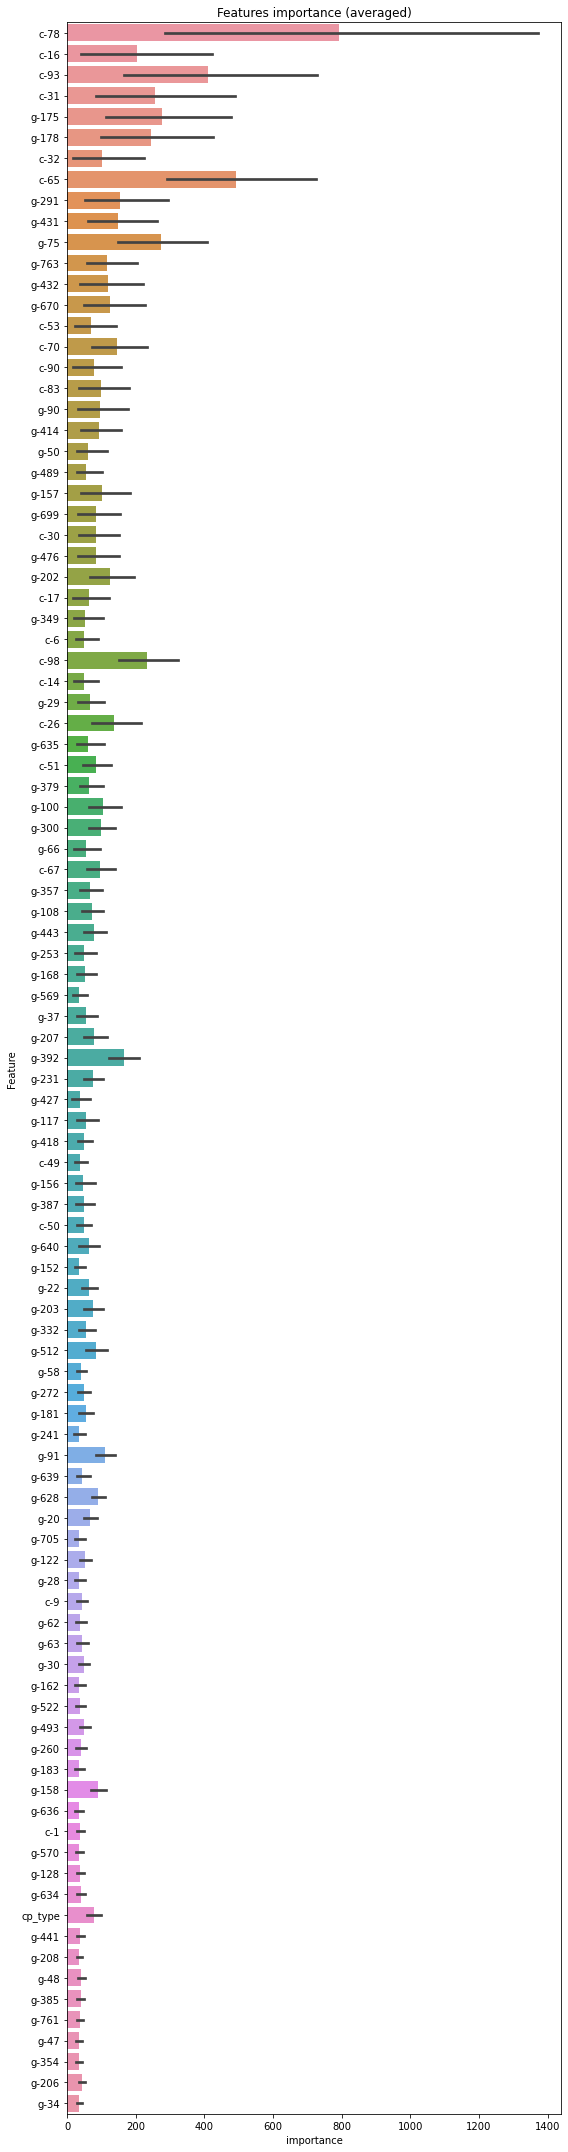

In [18]:
show_feature_importance(feature_importance_df)